# 분석시 유의사항
- 공통 전처리 파일들의 컬럼 앞글자 모두 대문자이지만
- 해당 분석에선 소문자만 사용합니다.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

art = pd.read_csv("data/articles_processed.csv")            # 상품 메타데이터
cust = pd.read_csv("data/customer_processed.csv")           # 고객 메타데이터
rev = pd.read_csv("data/total_revenue.csv")                 # 매출 데이터

# 안전하게 날짜형 변환
rev["T_Dat"] = pd.to_datetime(rev["T_Dat"])

# 한글 폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


In [2]:
art.columns = (
    art.columns
    .str.lower()
    .str.strip()
)

cust.columns = (
    cust.columns
    .str.lower()
    .str.strip()
)

rev.columns = (
    rev.columns
    .str.lower()
    .str.strip()
)

# 호출 테이블 검사

In [3]:
art.info()

<class 'pandas.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 12 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0   article_id                    105542 non-null  int64
 1   product_code                  105542 non-null  int64
 2   prod_name                     105542 non-null  str  
 3   product_type_info             105542 non-null  str  
 4   product_group_name            105542 non-null  str  
 5   graphical_appearance_info     105542 non-null  str  
 6   perceived_colour_master_info  105542 non-null  str  
 7   department_info               105542 non-null  str  
 8   index_info                    105542 non-null  str  
 9   index_group_info              105542 non-null  str  
 10  section_info                  105542 non-null  str  
 11  garment_group_info            105542 non-null  str  
dtypes: int64(2), str(10)
memory usage: 9.7 MB


- article_id              : 개별 상품을 식별하는 고유 ID
- product_code            : 동일한 디자인·모델을 묶는 상품 그룹 코드
- prod_name               : 상품 이름
- product_type_info       : 상품 유형을 나타내는 메타데이터
- product_group_name      : 상품 분류 메타데이터
- graphical_appearance_info     : 외형 메타데이터
- perceived_colour_master_info  : 색상군 메타데이터
- department_info         : 부서 메타데이터
- index_info              : index_group의 세부 라인/컬렉션 메타데이터
- index_group_info        : 타겟 고객군 메타데이터
- section_info            : 판매 섹션 메타데이터
- garment_group_info      : 의류 그룹 메타데이터

In [4]:
cust.info()

<class 'pandas.DataFrame'>
RangeIndex: 1047427 entries, 0 to 1047426
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype
---  ------                  --------------    -----
 0   customer_id             1047427 non-null  str  
 1   fn                      1047427 non-null  bool 
 2   active                  1047427 non-null  bool 
 3   club_member_status      1047427 non-null  str  
 4   fashion_news_frequency  371734 non-null   str  
 5   age                     1047427 non-null  int64
 6   age_group               1047427 non-null  str  
dtypes: bool(2), int64(1), str(4)
memory usage: 42.0 MB


- customer_id               : 고객 식별키
- Fn                        : 패션 뉴스 수신 여부
- active                    : 활성 고객 여부
- club_member_status        : 클럽 가입 상태 (신규 / 활성 / 탈퇴)
- fashion_news_frequency    : 뉴스 알림 주기
- age                       : 고객의 나이
- age_group                 : 고객의 나이태 분류

In [5]:
rev.info()

<class 'pandas.DataFrame'>
RangeIndex: 1037772 entries, 0 to 1037771
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1037772 non-null  datetime64[us]
 1   customer_id       1037772 non-null  str           
 2   article_id        1037772 non-null  int64         
 3   revenue           1037772 non-null  float64       
 4   sales_channel_id  1037772 non-null  int64         
 5   month             1037772 non-null  int64         
 6   year_month        1037772 non-null  str           
 7   month_day         1037772 non-null  str           
 8   total_revenue     1037772 non-null  float64       
 9   revenue_group     1037772 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(3), str(4)
memory usage: 79.2 MB


- t_dat                         : 거래일
- customer_id                   : 고객 식별키
- article_id                    : 상품 식별키
- revenue                       : 거래 1건의 구매금액
- sales_channel_id              : 판매 채널 1:오프라인 2: 온라인
- month                         : t_dat에서 뽑은 월 파생 컬럼
- year_month                    : t_dat를 연-월 단위로 묶은 문자열 파생 컬럼
- total_revenue                 : 해당 고객의 전체 구매금액 합계
- revenue_group                 : 해당 고객의 매출 등급(bottom_20 / middle / top_20)

# 분석 목표
- 전체 매출 규모 파악, 채널별 매출 현황
- 누적고객율과 비율을 통한 고객 특성 파악 및 구매 상품군 속성 분석
    - 고객 속성 파악, 상품군 속성 파악
- 누적고객 전환 시점을 통한 고객 특성 파악 및 구매 상품군 속성 분석
    - 고객 속성 파악, 상품군 속성 파악

공통목표
- 누적고객 분석
    - 신규 고객: 1회 이상 구매
    - 재구매 고객: 2회 이상 구매
    - 충성고객: 4회 이상 구매    

## 필요 테이블 조인

In [6]:
# ---------------------------------------------------------------------
# 분석용 total_revenue × customer
# 거래(매출, 날짜, 채널) + 고객 속성
# 상품은 단순 구매 대상이고 “무엇을 샀는지”는 부차적
# 어떤 고객이 매출을 만들고, 멤버십/뉴스레터는 효과가 있고 재구매 구조는 어떤한가?
# ---------------------------------------------------------------------

analysis_cust = (
    rev
    .merge(cust, on="customer_id", how="inner")
)
analysis_cust.columns

Index(['t_dat', 'customer_id', 'article_id', 'revenue', 'sales_channel_id',
       'month', 'year_month', 'month_day', 'total_revenue', 'revenue_group',
       'fn', 'active', 'club_member_status', 'fashion_news_frequency', 'age',
       'age_group'],
      dtype='str')

In [7]:
# ---------------------------------------------------------------------
# 분석용 total_revenue × articles
# "무엇이 팔렸는가"에 집중한 데이터
# 거래(매출, 날짜, 채널) + 상품 속성
# 고객 속성이 들어가 있지 않기 떄문에 고객 차이는 관심 대상 아님
# 매출을 구성하는 상품 구조 파악 (product_type / garment_group / section / 색상군 / 외형) 
# 월별 × 상품군 판매량으로 특정 시즌에 강한 상품 / 약한 상품 파악
# 매출 상위 몇 개 상품군에 집중되어 있는지
# ---------------------------------------------------------------------

analysis_art = (
    rev
    .merge(art, on="article_id", how="inner")
)
analysis_art.shape

(1037772, 21)

In [8]:
# ---------------------------------------------------------------------
# 전체 조인 (total_revenue × customer × articles)
# 볼수 있는 데이터
# 고객군별 선호 상품 연령대 × garment_group, 고객의 취향 파악 가능
# 이를 통해 타겟 전략 점검 가능 (특정 고객군이 특정 라인에 몰려 있는지)
# 가입한 사람이 아닌 소비한 고객을 골라야 하기 때문에 inner 사용
# ---------------------------------------------------------------------

analysis_master = (
    rev
    .merge(cust, on="customer_id", how="inner")
    .merge(art, on="article_id", how="inner")
)
analysis_master.shape

(804149, 27)

## 전체 매출 규모 파악, 채널별 매출 현황
- total_revenue : 전체 서비스에서 발생한 매출 규모
- transaction_cnt : 전체 거래 횟수
- customer_cnt : 구매 이력이 있는 실제 고객 수

In [9]:
total_revenue = analysis_cust["revenue"].sum()
transaction_cnt = analysis_cust["revenue"].count()
customer_cnt = analysis_cust["customer_id"].nunique()

overall_summary = pd.Series(
    {
        "total_revenue": total_revenue,
        "transaction_cnt": transaction_cnt,
        "customer_cnt": customer_cnt,
    }
)

overall_summary

total_revenue       21488.307641
transaction_cnt    804149.000000
customer_cnt       351503.000000
dtype: float64

**분석결과**<br>
전체 거래 데이터를 기준으로 분석한 결과, <br>
총 매출: 21488.30 SEK,<br>
총 거래 건수: 804,149건,<br>
구매 이력이 있는 고객 수: 353,503명으로 나타났습니다.

> 이번 분석에선 절대적인 매출 규모를 파악하기 어렵기 때문에 고객 등급 및 채널·상품군별 상대적인 매출 구조의 경향성에 초점을 맞추어 해석을 진행하였습니다.

### 월별 구매 현황

In [10]:
monthly_sales = (
    analysis_cust
    .groupby("year_month")
    .size()
    .reset_index(name="sales_cnt")
    .sort_values("year_month")
)

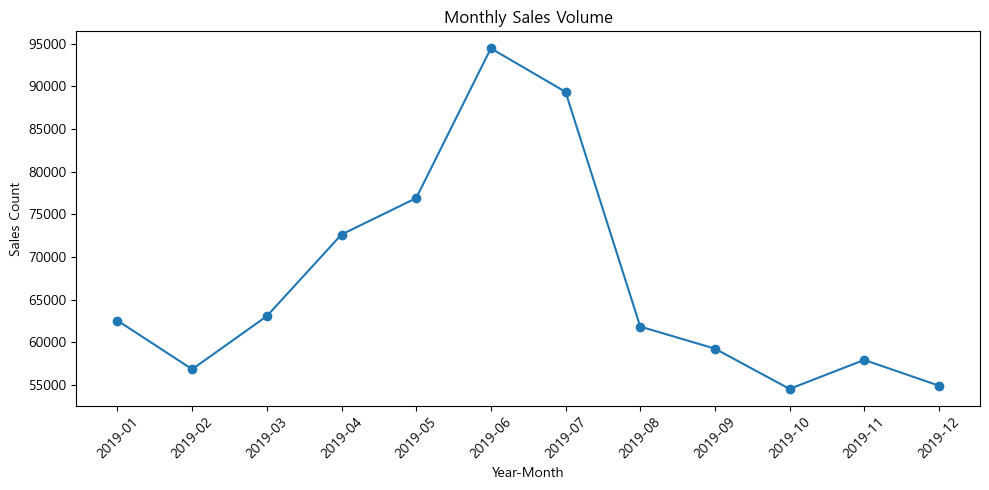

,year_month,sales_cnt
0,2019-01,62538
1,2019-02,56833
2,2019-03,63058
3,2019-04,72620
4,2019-05,76885
5,2019-06,94433
6,2019-07,89331
7,2019-08,61834
8,2019-09,59248
9,2019-10,54530


In [11]:
plt.figure(figsize=(10,5))
plt.plot(
    monthly_sales["year_month"],
    monthly_sales["sales_cnt"],
    marker="o"
)

plt.title("Monthly Sales Volume")
plt.xlabel("Year-Month")
plt.ylabel("Sales Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_sales

관측
- 총 거래 건수: 804,149건
- 6~7월: 연중 최고 판매량
- 8월 이후: 판매량 급감
- 11~12월: 연중 하위권 판매량 구간
- 10 → 11월: 소폭 반등은 있으나 구조적 회복은 아님

### 채널별 매출 매출 비중

In [12]:
# 채널별 매출과 거래 수
channel_overview = (
    analysis_cust
    .groupby("sales_channel_id")
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count")
    )
)

# 채널 비중 계산
channel_ratio = channel_overview.copy()

channel_ratio["revenue_ratio"] = (
    channel_ratio["revenue_sum"]
    / channel_ratio["revenue_sum"].sum()
)

channel_ratio["transaction_ratio"] = (
    channel_ratio["transaction_cnt"]
    / channel_ratio["transaction_cnt"].sum()
)


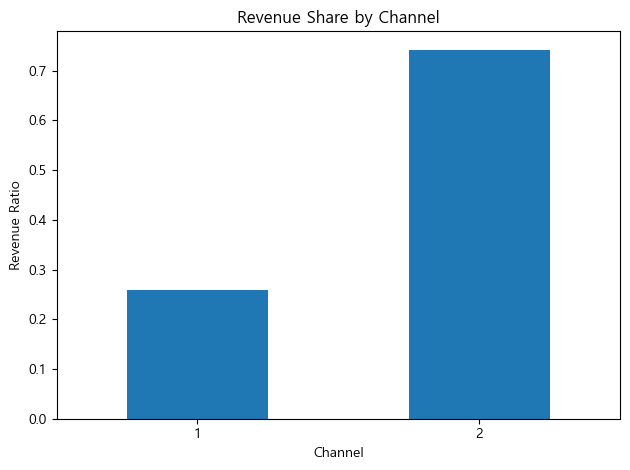

,revenue_sum,transaction_cnt,revenue_ratio,transaction_ratio
sales_channel_id,,,,
1,5547.886296,246592,0.258182,0.30665
2,15940.421345,557557,0.741818,0.69335


In [13]:
# 시각화

channel_ratio["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Channel")
plt.xlabel("Channel")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

channel_ratio

온라인 채널
- 매출 비중: 약 74.1%
- 거래 비중: 약 69.3%

오프라인 채널
- 매출 비중: 약 25.8%
- 거래 비중: 약 30.6%

온라인 채널은 거래 비중 대비 매출 비중이 더 높게 나타났으며, 이는 온라인 채널에서의 평균 거래 금액이 오프라인 채널보다 더 높은 경향을 보이는것을 의미합니다. <br>
반면에 오프라인 채널은 거래 비중 대비 매출 기여도가 상대적으로 낮은편으로, 예측컨데 비교적 저가 상품중심의 구매가 이루어졌을 가능성이 존재합니다.


> 이를 시각화한 결과, 온라인 채널이 전체 매출에서 차지하는 비중이 오프라인 채널보다 크게 나타났습니다.<br>
매출구조는 제대로 파악할수 없기 때문에 상대적인 경향성 파악에 초점을 둔 해석입니다. <br> 현실과의 어느정도 차이를 보일순 있으나, 경향성을 가짐에는 변함없습니다.

### 멤버십 상태별 매출 비중

In [14]:
member_overview = (
    analysis_cust
    .groupby("club_member_status", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count"),
        customer_cnt=("customer_id", "nunique")
    )
)

member_overview["revenue_ratio"] = (
    member_overview["revenue_sum"]
    / member_overview["revenue_sum"].sum()
)

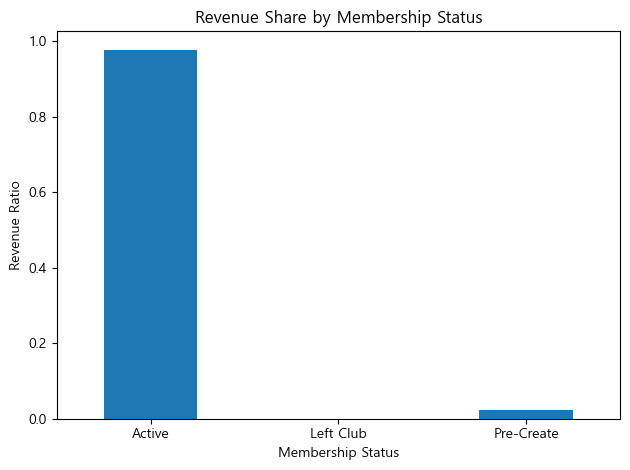

In [15]:
member_overview.set_index("club_member_status")["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Membership Status")
plt.xlabel("Membership Status")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


멤버십 상태별 매출을 분석한 결과, ACTIVE 멤버십 고객이 전체 매출의 약 97.7%를 차지하는 것으로 나타났습다.<br>
반면, PRE-CREATE 고객은 약 2.2%, LEFT CLUB 고객은 매우 미미한 수준의 매출 비중을 보입니다.<br>
즉, 이는 현재 활성화된 멤버십 고객이 서비스 매출의 핵심 고객군임을 보여줍니다.

> 다만, 멤버십 상태가 매출의 직접적인 원인임을 의미하지 않으며 구매 활동이 활발한 고객이 멤버십을 유지하고 있을 가능성이 있기 때문에 큰 의미가 있다 볼순 없습다

### 뉴스 구독(FN) 여부별 매출 비중

In [16]:
fn_overview = (
    analysis_cust
    .groupby("fn", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count"),
        customer_cnt=("customer_id", "nunique")
    )
)

fn_overview["revenue_ratio"] = (
    fn_overview["revenue_sum"]
    / fn_overview["revenue_sum"].sum()
)

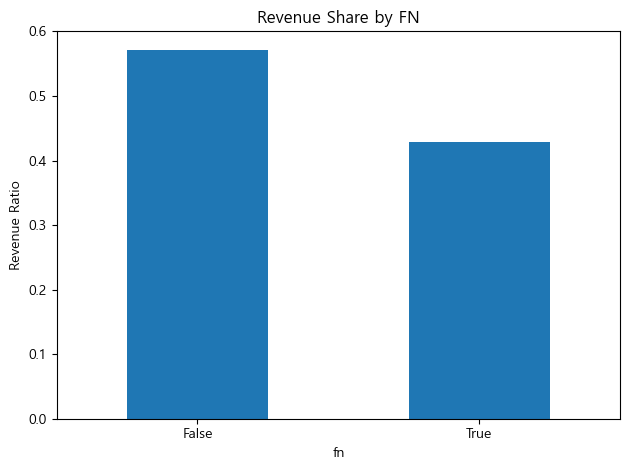

,fn,revenue_sum,transaction_cnt,customer_cnt,revenue_ratio
0,False,12283.287928,456165,208220,0.571627
1,True,9205.019714,347984,143283,0.428373


In [17]:
fn_overview.set_index("fn")["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by FN")
plt.xlabel("fn")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

fn_overview


뉴스레터 수신 여부에 따른 매출을 분석한 결과, 뉴스를 수신하지 않는 고객이 약 57.1%, 뉴스를 수신하는 고객이 약 42.9%의 매출 비중을 차지하는것을 확인하였다. <br>

> 뉴스레터 수신 여부에 따라 매출 규모 차이가 관찰되었으나, 이는 고객 수 차이에 따른 결과일 가능성이 있다.

### Active 여부별 매출 비중

In [18]:
active_overview = (
    analysis_cust
    .groupby("active", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count"),
        customer_cnt=("customer_id", "nunique")
    )
)

active_overview["revenue_ratio"] = (
    active_overview["revenue_sum"]
    / active_overview["revenue_sum"].sum()
)

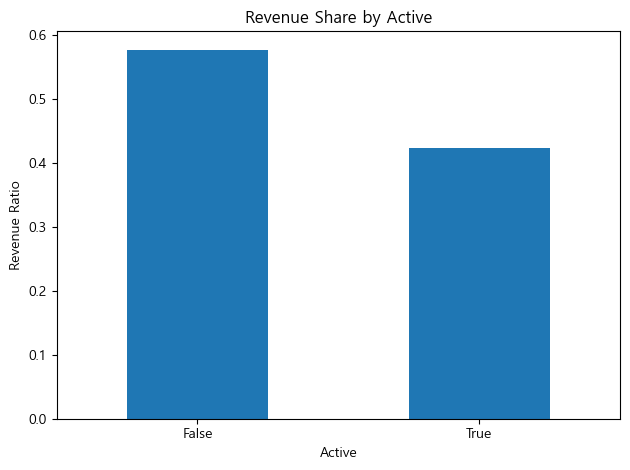

,active,revenue_sum,transaction_cnt,customer_cnt,revenue_ratio
0,False,12402.680368,460828,210476,0.577183
1,True,9085.627273,343321,141027,0.422817


In [19]:
active_overview.set_index("active")["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Active")
plt.xlabel("Active")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

active_overview


고객의 활동 상태(Active 여부)에 따른 매출을 분석한 결과:
- 비활성(False) 고객이 약 57.7%, 
- 활성(True) 고객이 약 42.3%

의 매출 비중을 차지했습니다.<br>
Active 고객은 고객 수 대비 상대적으로 높은 매출 기여도를 보이는 경향이 있다 할수 있습니다.

> Active 변수는 고객의 최근 활동 여부를 나타내는 상태 정보로, 매출의 원인보다는 현재 고객 특성을 설명하는 지표로 해석하였습니다.

### 상위 하위 20% 비중/고객 등급별 매출 비중

In [20]:
revenue_group_overview = (
    analysis_cust
    .groupby("revenue_group")
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count")
    )
)

# 비중
revenue_group_overview["revenue_ratio"] = (
    revenue_group_overview["revenue_sum"]
    / revenue_group_overview["revenue_sum"].sum()
)


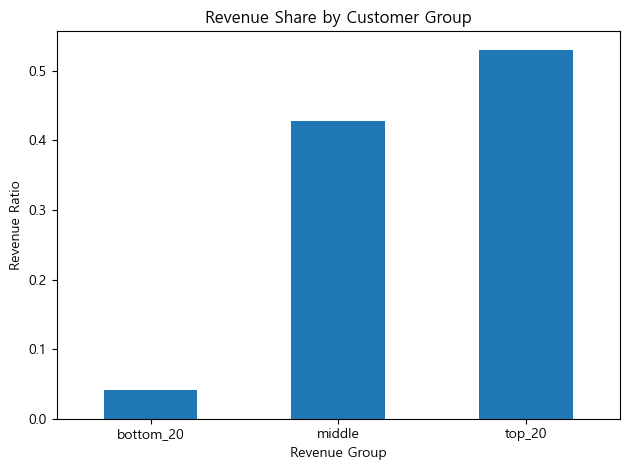

,revenue_sum,transaction_cnt,revenue_ratio
revenue_group,,,
bottom_20,889.174958,73566,0.041379
middle,9203.948886,359546,0.428324
top_20,11395.183797,371037,0.530297


In [21]:
revenue_group_overview["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Customer Group")
plt.xlabel("Revenue Group")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

revenue_group_overview

상위 하위 20% 비중/고객 등급별 매출 비중을 분석한 결과:
- 상위 20% 고객들은 거래를 더 자주 하기 때문에 고객 수는 20%여도, 거래 행에서는 45% 정도
- 하위 20% 고객은 거래 횟수와 매출 기여도 모두 낮은 수준을 띔

> 거래 기준 분포에서 상위 고객군(top_20)이 전체 거래의 약 46%를 차지하였습니다.<br>이는 상위 고객군이 평균적으로 더 빈번하게 구매하는 경향이 있음을 시사합니다.

> 매출 금액은 데이터 전처리 과정에서 스케일이 변형되었을 가능성이 있어 절대값 해석보다는 그룹 간 상대 비교에 초점을 맞추었습니다.

## 상품 속성별 매출 현황

### 의류 그룹 

In [22]:
# 의류 그룹 (상의, 하의, 아우터 등)
garment_overview = (
    analysis_art
    .groupby("garment_group_info", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        transaction_cnt=("revenue", "count")
    )
    .sort_values("revenue_sum", ascending=False)
)

garment_overview["revenue_ratio"] = (
    garment_overview["revenue_sum"]
    / garment_overview["revenue_sum"].sum()
)

garment_overview["transaction_ratio"] = (
    garment_overview["transaction_cnt"]
    / garment_overview["transaction_cnt"].sum()
)

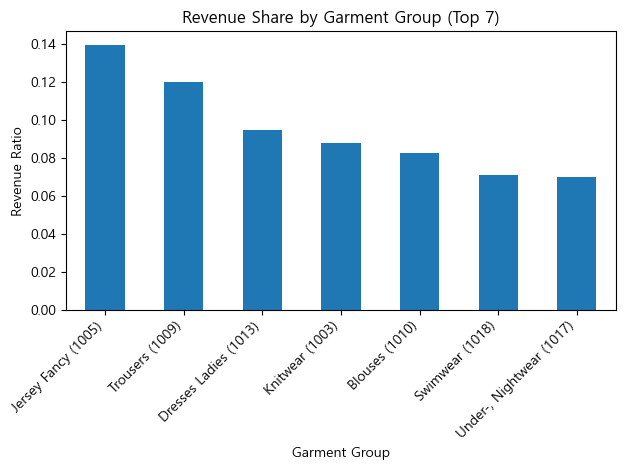

In [23]:
top_garments = garment_overview.head(7)

import matplotlib.pyplot as plt

top_garments.set_index("garment_group_info")["revenue_ratio"].plot(kind="bar")
plt.title("Revenue Share by Garment Group (Top 7)")
plt.xlabel("Garment Group")
plt.ylabel("Revenue Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

상품군별 매출 비중을 막대그래프로 시각화한 결과, 매출이 특정 상품군에 고르게 분포되어 있기보다는 상위 상품군에 집중되는 구조임을 확인할 수 있다.

- 매출은 Jersey 계열, 바지, 원피스 등 주요 의류 상품군을 중심으로 형성되어 있다.
- 일부 상품군은 거래 대비 매출 기여도가 높아 상대적으로 고가 상품군의 특성을 보인다.
- 반대로 기본 의류 상품군은 거래 빈도는 높으나 매출 기여도는 상대적으로 낮다.


> 상품군별 매출 분포를 기준으로 한 결과로, 공급량, 가격 정책, 이밴트(프로모션?) 등 외부 요인은 반영되지 않았습니다.

### 의문1: 특정월에(시즌 중)에 악세사리가 많이 팔리나?

In [24]:
analysis_art["product_group_name"].value_counts()

product_group_name
Garment Upper body       408672
Garment Lower body       231720
Garment Full body        115891
Swimwear                  89657
Underwear                 80652
Accessories               52162
Shoes                     24587
Socks & Tights            21267
Nightwear                 11283
Unknown                    1468
Bags                        221
Items                       111
Cosmetic                     29
Furniture                    29
Underwear/nightwear          17
Garment and Shoe care         5
Interior textile              1
Name: count, dtype: int64

In [25]:
analysis_art[
    analysis_art["product_group_name"].str.contains("access", case=False, na=False)
]["product_type_info"].value_counts()

product_type_info
Bag (66)                  7462
Belt (67)                 6435
Earring (70)              5856
Scarf (80)                5074
Sunglasses (81)           4545
Necklace (77)             4233
Hair/alice band (74)      3044
Other accessories (78)    2716
Hat/beanie (75)           2659
Hair ties (512)           1560
Hair clip (72)            1290
Hair string (73)          1216
Ring (79)                 1135
Gloves (71)               1002
Cap/peaked (69)            919
Hat/brim (76)              914
Bracelet (68)              319
Earrings (508)             281
Watch (85)                 237
Tie (82)                   205
Dog Wear (231)             201
Beanie (496)               199
Wallet (84)                166
Hairband (511)              78
Waterbottle (156)           72
Braces (499)                69
Umbrella (83)               52
Straw hat (515)             41
Bucket hat (503)            36
Soft Toys (155)             35
Cap (504)                   31
Felt hat (509)       

In [26]:
acc_month = (
    analysis_art[
        analysis_art["product_group_name"].str.contains("access", case=False, na=False)
    ]
    .groupby("year_month", as_index=False)
    .agg(revenue_sum=("revenue", "sum"))
)

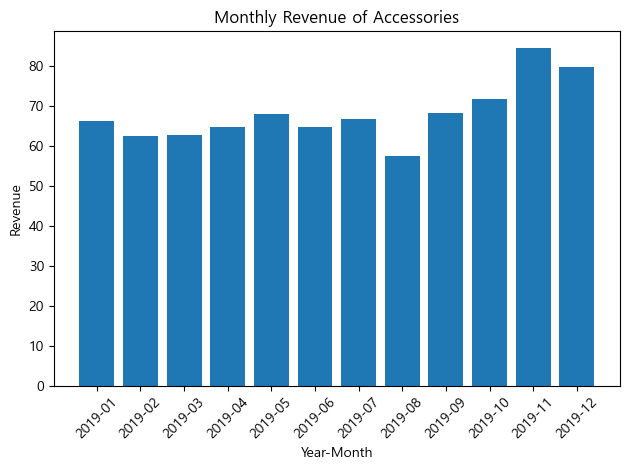

,year_month,revenue_sum
0,2019-01,66.310203
1,2019-02,62.606780
2,2019-03,62.675542
3,2019-04,64.856729
4,2019-05,68.001627
5,2019-06,64.798271
6,2019-07,66.867203
7,2019-08,57.438881
8,2019-09,68.264508
9,2019-10,71.864559


In [27]:
plt.figure()
plt.bar(acc_month["year_month"], acc_month["revenue_sum"])
plt.title("Monthly Revenue of Accessories")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

acc_month

### 의문 2: 학기 시작 전에 옷 구매량
- 스웨덴의 가을학기(8~9) 봄학기 (1월)
- 학기 직전을 1개월(7월 12월)~ 2개월 (6월/11월)

In [28]:
youth_clothes = analysis_master[
    (analysis_master["age_group"].isin(["10s", "20s"])) &
    (analysis_master["product_group_name"].str.contains("Garment", case=False, na=False))
].copy()

youth_clothes["month"] = youth_clothes["year_month"].str[-2:].astype(int)

In [29]:
monthly_purchase_cnt = (
    youth_clothes
    .groupby("year_month", as_index=False)
    .agg(
        purchase_cnt=("revenue", "count")
    )
    .sort_values("year_month")
)

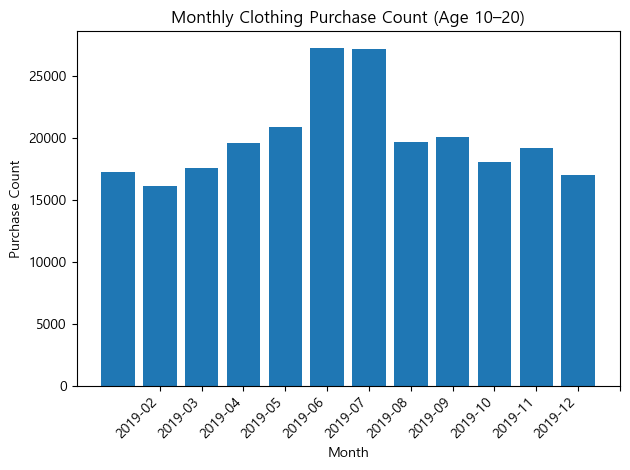

,year_month,purchase_cnt
0,2019-01,17261
1,2019-02,16099
2,2019-03,17559
3,2019-04,19620
4,2019-05,20885
5,2019-06,27244
6,2019-07,27178
7,2019-08,19702
8,2019-09,20077
9,2019-10,18097


In [30]:
plt.figure()
plt.bar(monthly_purchase_cnt["year_month"], monthly_purchase_cnt["purchase_cnt"])
plt.title("Monthly Clothing Purchase Count (Age 10–20)")
plt.xlabel("Month")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Purchase Count")
plt.xticks(range(1, 13))
plt.tight_layout()
plt.show()

monthly_purchase_cnt

#### 의문2-1: 6~7월에 무엇이 많이 팔리는건가?

In [31]:
youth_6_7 = analysis_master[
    (analysis_master["age_group"].isin(["10s", "20s"])) &
    (analysis_master["year_month"].str.endswith(("-06", "-07"))) &
    (analysis_master["product_group_name"].str.contains("Garment", case=False, na=False))
].copy()

garment_6_7_summary = (
    youth_6_7
    .groupby("product_group_name", as_index=False)
    .agg(
        purchase_cnt=("revenue", "count")
    )
    .sort_values("purchase_cnt", ascending=False)
)



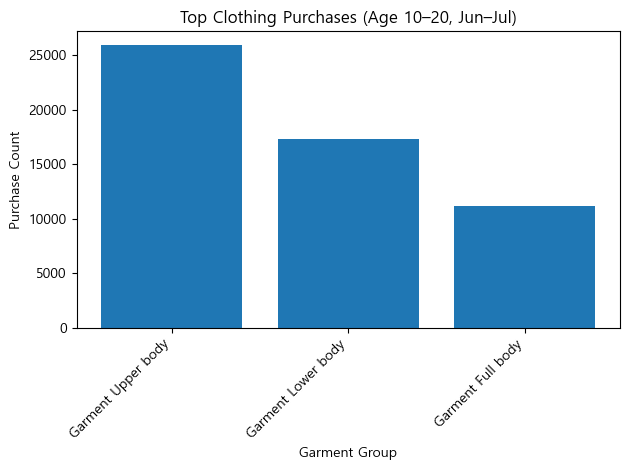

,product_group_name,purchase_cnt
2,Garment Upper body,25907
1,Garment Lower body,17300
0,Garment Full body,11215


In [32]:
top10_garments = garment_6_7_summary.head(10)

plt.figure()
plt.bar(
    top10_garments["product_group_name"],
    top10_garments["purchase_cnt"]
)
plt.title("Top Clothing Purchases (Age 10–20, Jun–Jul)")
plt.xlabel("Garment Group")
plt.ylabel("Purchase Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

top10_garments


### 의문3: 여름시즌(5~7)에 운동복과 수영복이 많이 팔리는가?

In [33]:
activewear = analysis_master[
    (analysis_master["product_group_name"] == "Swimwear") |
    (analysis_master["product_group_name"].str.contains("Outdoor|Sport|Active", case=False))
]


activewear_monthly = (
    activewear
    .groupby("year_month", as_index=False)
    .agg(
        revenue_sum=("revenue", "sum"),
        purchase_cnt=("revenue", "count")
    )
    .sort_values("year_month")
)

activewear_monthly


,year_month,revenue_sum,purchase_cnt
0,2019-01,98.206440,4285
1,2019-02,92.298016,3834
2,2019-03,143.288050,5710
3,2019-04,212.652559,8618
4,2019-05,268.892304,11265
5,2019-06,370.189762,14646
6,2019-07,260.950897,13088
7,2019-08,74.218068,4860
8,2019-09,19.521881,1120
9,2019-10,12.171373,730


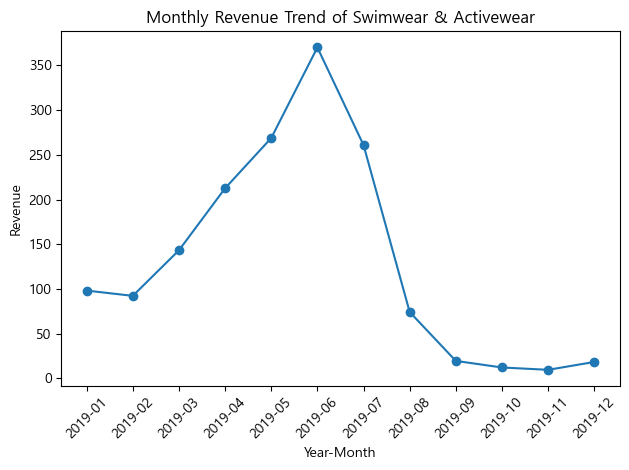

In [34]:
plt.figure()
plt.plot(activewear_monthly["year_month"], activewear_monthly["revenue_sum"], marker="o")
plt.title("Monthly Revenue Trend of Swimwear & Activewear")
plt.xlabel("Year-Month")
plt.ylabel("Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

5~7월 기간 동안 고객의 의류 구매 비중을 월별로 분석한 결과. <br>
전체 의류 구매량 증가와 함께 수영복 및 운동·아웃도어 의류의 구매 비중 변화가 관찰되었습니다.

# 누적구매율과 비중으로 확인하는 고객 분류

## 필요 테이블 생성

In [35]:
# 필요컬럼 호출
tx = analysis_cust[["customer_id", "t_dat", "year_month"]].copy()

# 날짜형 변경
tx["t_dat"] = pd.to_datetime(tx["t_dat"])


# 고객별로 날짜 순 정렬
tx = tx.sort_values(["customer_id", "t_dat"])

# 고객별 누적 구매 횟수
tx["transaction_cnt"] = (
    tx
    .groupby("customer_id")
    .cumcount() + 1
)

tx.head()

,customer_id,t_dat,year_month,transaction_cnt
77235,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-05-25,2019-05,1
677888,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2019-09-28,2019-09,2
696491,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-05-07,2019-05,1
600809,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-05-22,2019-05,2
522736,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,2019-06-18,2019-06,3


In [36]:
tx.info()

<class 'pandas.DataFrame'>
Index: 804149 entries, 77235 to 4300
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   customer_id      804149 non-null  str           
 1   t_dat            804149 non-null  datetime64[us]
 2   year_month       804149 non-null  str           
 3   transaction_cnt  804149 non-null  int64         
dtypes: datetime64[us](1), int64(1), str(2)
memory usage: 30.7 MB


In [37]:
# 고객-월 단위로 "그 달까지 누적 구매 횟수" 만들기
# 한 달에 여러 번 사도, 그 달의 누적 상태는 max가 대표
monthly_customer = (
    tx
    .groupby(["year_month", "customer_id"], as_index=False)
    .agg(
        transaction_cnt=("transaction_cnt", "max")
    )
)

monthly_customer.info()

<class 'pandas.DataFrame'>
RangeIndex: 612550 entries, 0 to 612549
Data columns (total 3 columns):
 #   Column           Non-Null Count   Dtype
---  ------           --------------   -----
 0   year_month       612550 non-null  str  
 1   customer_id      612550 non-null  str  
 2   transaction_cnt  612550 non-null  int64
dtypes: int64(1), str(2)
memory usage: 14.0 MB


- tx: 1행 = 1번의 구매(거래): 804149
    - 같은 고객이 같은 달에 여러 번 구매하면 여려 행이 존재

- monthly_customer: 612550
    - 같은 고객이 같은 달에 여러 번 구매했더라도 그 달의 ‘누적 구매 횟수 최종값’만 남긴다.
    - 같은 고객의 여러 거래를 1행으로 압축

때문에 행 감소 발생은 당연한 수치다.

In [38]:
# 누적 구매횟수 기준으로 고객 유형 분류

# 신규고객 배정
monthly_customer["customer_type"] = "New"

# 재구매 고객 분류
monthly_customer.loc[
    monthly_customer["transaction_cnt"] >= 2,
    "customer_type"
] = "Repeat"

# 충성 고객 분류
monthly_customer.loc[
    monthly_customer["transaction_cnt"] >= 4,
    "customer_type"
] = "Loyal"

# 분류고객 합산 결과
monthly_customer["customer_type"].value_counts()

customer_type
New       282165
Repeat    210846
Loyal     119539
Name: count, dtype: int64

## 누적 고객분석

In [39]:
# 월별로 고객 유형별 "고객 수" 세기
monthly_count = (
    monthly_customer
    .groupby(["year_month", "customer_type"], as_index=False)
    .agg(
        customer_cnt=("customer_id", "nunique") # 거래행이 아닌 고객으로 카운트
    )
)

# 월별로 고객 유형별 "고객 수" 비중
# 고객유형별 고객 수 / 해당 월 전체 고객 수

monthly_count["ratio"] = (
    monthly_count["customer_cnt"]
    / monthly_count
        .groupby("year_month")["customer_cnt"]
        .transform("sum")
)

monthly_count.isna().sum()

year_month       0
customer_type    0
customer_cnt     0
ratio            0
dtype: int64

In [40]:
# 누적구매율 pivot 형태로 변환
pivot_cnt = (
    monthly_count
    .pivot(
        index="year_month", # x
        columns="customer_type", # (New / Repeat / Loyal) y
        values="customer_cnt" # y
    )
    .fillna(0)
    .sort_index()
)

# 누적구매 비중 pivot 형태로 변환
pivot_ratio = (
    monthly_count
    .pivot(
        index="year_month", 
        columns="customer_type", 
        values="ratio"
    )
    .fillna(0)
    .sort_index()
)

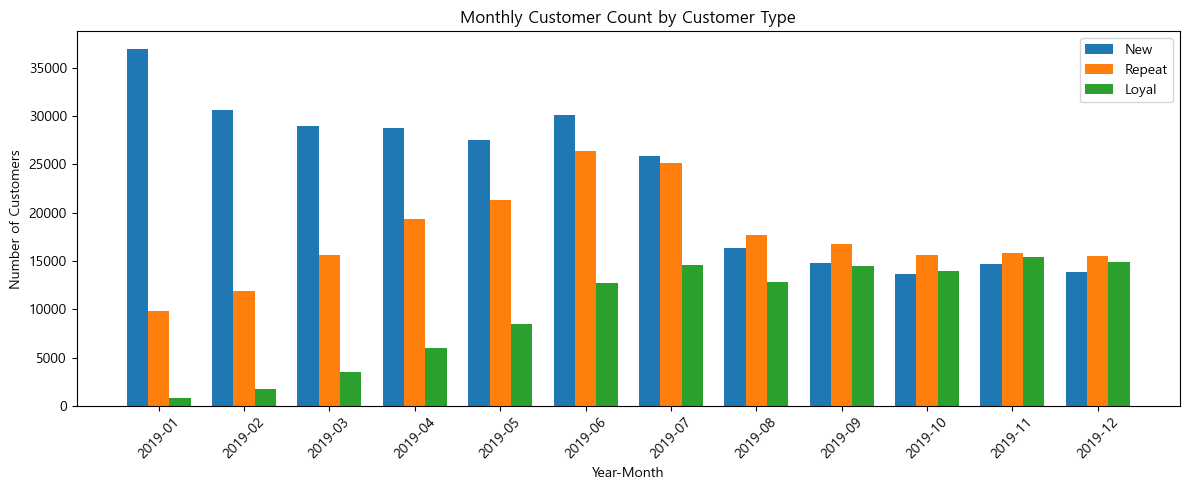

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,849,36928,9837
2019-02,1764,30663,11873
2019-03,3543,28977,15583
2019-04,6036,28767,19330
2019-05,8446,27546,21361
2019-06,12684,30095,26354
2019-07,14538,25846,25138
2019-08,12827,16308,17666
2019-09,14497,14751,16747


In [41]:
# 고객유형별 막대그래프 (나란히 배치)
x = np.arange(len(pivot_cnt.index))   # 월 위치
width = 0.25                          # 막대 너비

plt.figure(figsize=(12, 5))

# 왼쪽: New 고객
plt.bar(
    x - width,
    pivot_cnt["New"],
    width=width,
    label="New"
)

# 가운데: Repeat 고객
plt.bar(
    x,
    pivot_cnt["Repeat"],
    width=width,
    label="Repeat"
)

# 오른쪽: Loyal 고객
plt.bar(
    x + width,
    pivot_cnt["Loyal"],
    width=width,
    label="Loyal"
)

plt.title("Monthly Customer Count by Customer Type")
plt.xlabel("Year-Month")
plt.ylabel("Number of Customers")
plt.xticks(x, pivot_cnt.index, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

pivot_cnt

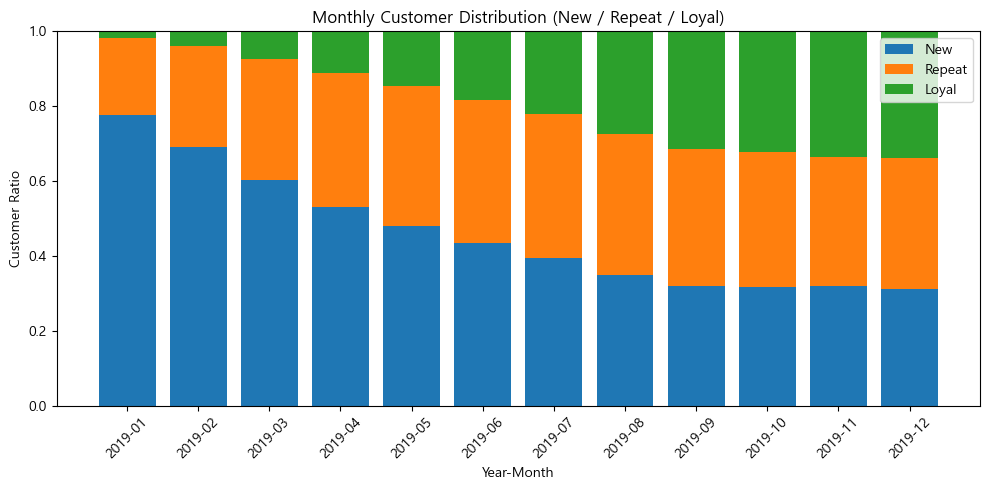

customer_type,Loyal,New,Repeat
year_month,,,
2019-01,0.017831,0.775570,0.206599
2019-02,0.039819,0.692167,0.268014
2019-03,0.073654,0.602395,0.323951
2019-04,0.111503,0.531413,0.357083
2019-05,0.147263,0.480289,0.372448
2019-06,0.183472,0.435320,0.381207
2019-07,0.221880,0.394463,0.383657
2019-08,0.274075,0.348454,0.377471
2019-09,0.315186,0.320709,0.364105


In [42]:
plt.figure(figsize=(10, 5))

# New 고객
plt.bar(
    pivot_ratio.index,
    pivot_ratio["New"],
    label="New"
)

# Repeat 고객
plt.bar(
    pivot_ratio.index,
    pivot_ratio["Repeat"],
    bottom=pivot_ratio["New"],
    label="Repeat"
)

# Loyal 고객
plt.bar(
    pivot_ratio.index,
    pivot_ratio["Loyal"],
    bottom=pivot_ratio["New"] + pivot_ratio["Repeat"],
    label="Loyal"
)

plt.title("Monthly Customer Distribution (New / Repeat / Loyal)")
plt.xlabel("Year-Month")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

pivot_ratio

누적 구매율과 비중의 분석결과

> 본 분석에서는 고객의 누적 구매 횟수를 기준으로 고객 유형을 분류하였습니다. <br> 
총 구매 횟수가 2회 이상인 고객을 재구매 고객(Repeat), 4회 이상인 고객을 충성 고객(Loyal)으로 정의해 반복 구매 강도에 따른 고객 구조를 분석을 실시하였습니다.


> 본 분석은 누적이기 때문에 전환율은 측정할수 없음

- 시간이 지날수록 신규 고객(New)의 비중 감소
- 재구매 고객(Repeat)이 안정적으로 증가
- 충성 고객(Loyal, 4회 이상 구매)의 비중이 꾸준히 누적

- 신규 고객 비중은 절반 이하로 감소한다.
    - 2019-01: 77.6%
    - 2019-06: 43.5%
    - 2019-12: 31.3%
- 신규 유입이 줄었다기보다 기존 고객이 Repeat·Loyal로 이동하며 비중이 낮아진 것

- 재구매 고객
- 2019-01: 20.7%
- 2019-05: 37.2%
- 2019-08: 37.7%
- 2019-12: 35.0%

- 충성고객
- 2019-01: 1.8%
- 2019-04: 11.2%
- 2019-08: 27.4%
- 2019-12: 33.7%

> Loyal 기준을 4회 이상 구매로 잡았음에도 연말에 고객의 1/3이 충성 고객

## 누적구매율과 비중으로 확인하는 고객 속성 분석

In [43]:
customer_summary = (
    analysis_cust
    .sort_values("t_dat")
    .groupby("customer_id", as_index=False)
    .agg(
        # 누적 구매 횟수
        transaction_cnt=("t_dat", "size"),

        # 고객 속성 (첫 유입 시점 기준)
        age_group=("age_group", "first"),
        FN=("fn", "first"),
        club_member_status=("club_member_status", "first"),
        Active=("active", "first"),

        # 매출 그룹 (이미 계산된 것 사용)
        revenue_group=("revenue_group", "first"),
    )
)

customer_summary.columns

Index(['customer_id', 'transaction_cnt', 'age_group', 'FN',
       'club_member_status', 'Active', 'revenue_group'],
      dtype='str')

In [44]:
customer_summary["revenue_group"].value_counts()

revenue_group
middle       209772
top_20        71027
bottom_20     70704
Name: count, dtype: int64

In [45]:
# 신규 / 재구매 / 충성 고객 분류
customer_summary["customer_type"] = "New"

customer_summary.loc[
    customer_summary["transaction_cnt"] >= 2,
    "customer_type"
] = "Repeat"

customer_summary.loc[
    customer_summary["transaction_cnt"] >= 4,
    "customer_type"
] = "Loyal"

customer_summary["customer_type"].value_counts()

customer_type
New       174690
Repeat    117966
Loyal      58847
Name: count, dtype: int64

### 고객 타입 x 연령대 분석

In [46]:
age_dist = (
    customer_summary
    .groupby(["customer_type", "age_group"])
    .size()
    .reset_index(name="customer_cnt")
)

age_dist["ratio"] = (
    age_dist["customer_cnt"]
    / age_dist
        .groupby("customer_type")["customer_cnt"]
        .transform("sum")
)

age_pivot = (
    age_dist
    .pivot(
        index="age_group",
        columns="customer_type",
        values="ratio"
    )
    .fillna(0)
    .sort_index()
)


<Figure size 640x480 with 0 Axes>

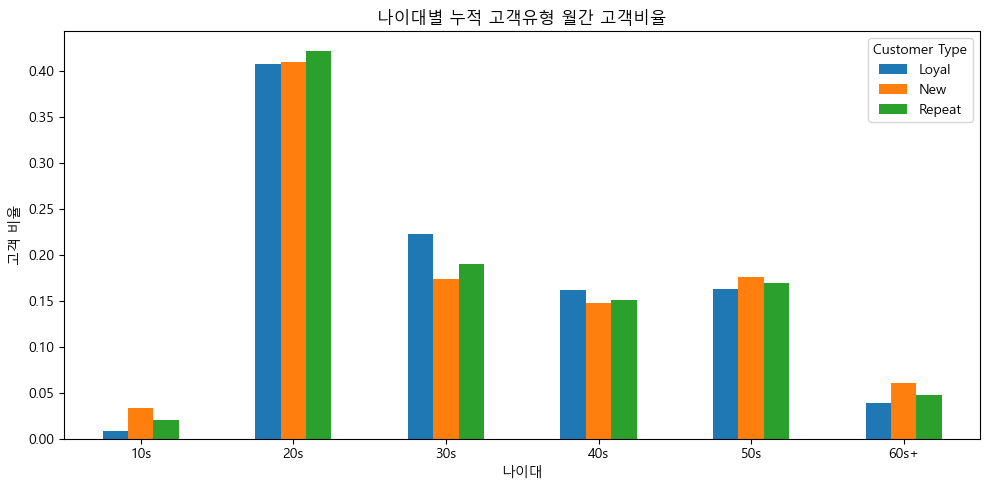

customer_type,Loyal,New,Repeat
age_group,,,
10s,0.008531,0.033013,0.020430
20s,0.406886,0.410092,0.421850
30s,0.222713,0.173290,0.189877
40s,0.161096,0.147312,0.150721
50s,0.162625,0.176112,0.169439
60s+,0.038150,0.060181,0.047683


In [47]:
plt.figure()

age_pivot.plot(
    kind="bar",
    figsize=(10, 5)
)

plt.title("나이대별 누적 고객유형 월간 고객비율")
plt.xlabel("나이대")
plt.ylabel("고객 비율")
plt.xticks(rotation=0)
plt.legend(title="Customer Type")
plt.tight_layout()
plt.show()

age_pivot

- 10대: 전체 비중 자체가 매우 낮고 충성 고객 비중은 거의 없음 <br>
→ 구매 지속성·충성도 형성 가능성 낮음

- 20대: 모든 고객 유형에서 가장 높은 비중 (약 40% 이상) <br>
신규 → 재구매 → 충성으로 갈수록 큰 변화 없음
> 유입의 중심 연령대. 단, 20대라고 해서 자동으로 충성 고객이 되는 구조는 아니기에 “전환 전략”이 중요한것으로 판단됩니다

- 30대: 신규 고객 대비 재구매·충성 고객에서 비중이 더 높음. 특히 충성 고객이 가장 큰 비중을 차지합니다.
> 충성 고객 전환 가능성이 높은 핵심 연령대로 장기 고객 가치가 크다 볼수 있습다.

### 고객특성별 분석

In [48]:
# 타겟 고객군 필터링
target_2030 = customer_summary[
    customer_summary["age_group"].isin(["20s", "30s"])
].copy()

target_2030.shape

(211124, 8)

### 고객 타입 X 특정 나이대(20~30대) X FN

In [49]:
fn_dist = (
    target_2030
    .groupby(["age_group", "customer_type", "FN"])
    .size()
    .reset_index(name="customer_cnt")
)
# 20~30대 중에서 이 고객 타입에서
# FN=True / False 고객이 몇 명?

fn_dist["ratio"] = (
    fn_dist["customer_cnt"]
    / fn_dist
        .groupby(["age_group", "customer_type"])["customer_cnt"]
        .transform("sum")
)

fn_pivot = (
    fn_dist
    .pivot(
        index=["age_group", "customer_type"],
        columns="FN",
        values="ratio"
    )
    .fillna(0)
)
fn_20s = fn_pivot.loc["20s"]
fn_30s = fn_pivot.loc["30s"]

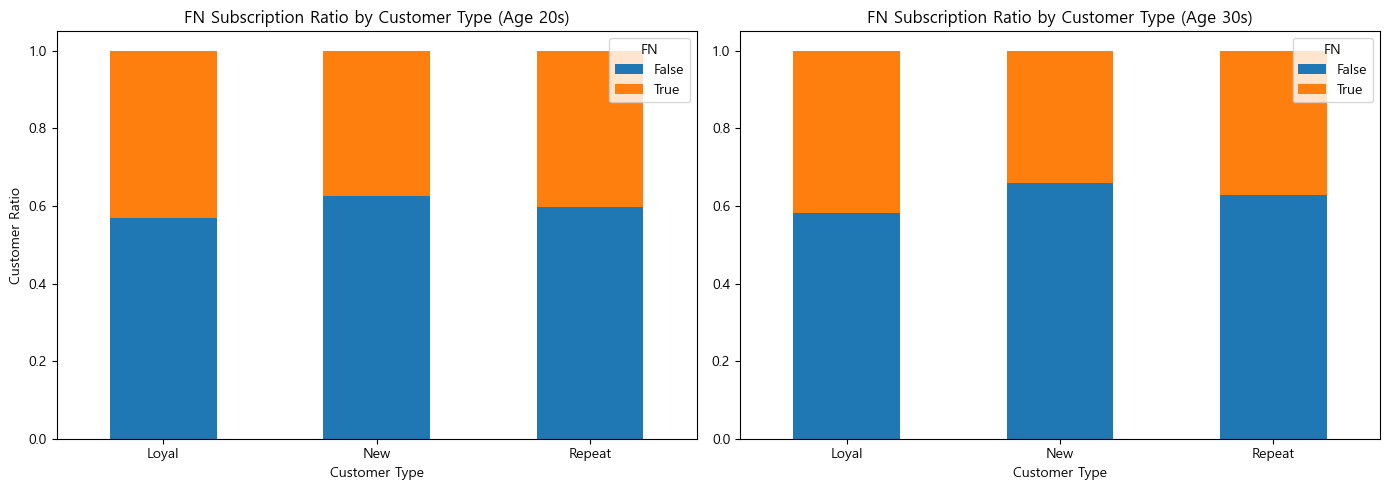

FN                          False     True 
age_group customer_type                    
20s       Loyal          0.568368  0.431632
          New            0.625358  0.374642
          Repeat         0.596938  0.403062
30s       Loyal          0.581566  0.418434
          New            0.659652  0.340348
          Repeat         0.627216  0.372784

In [50]:
plt.figure(figsize=(14, 5))

# ===== 20대 =====
plt.subplot(1, 2, 1)

fn_20s.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)

plt.title("FN Subscription Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=0)
plt.legend(title="FN")


# ===== 30대 =====
plt.subplot(1, 2, 2)

fn_30s.plot(
    kind="bar",
    stacked=True,
    ax=plt.gca()
)

plt.title("FN Subscription Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.xticks(rotation=0)
plt.legend(title="FN")


plt.tight_layout()
plt.show()

fn_pivot

### 고객 타입 X 특정 나이대(20~30대) X 맴버십

In [51]:
member_dist = (
    target_2030
    .groupby(["age_group", "customer_type", "club_member_status"])
    .size()
    .reset_index(name="customer_cnt")
)

member_dist["ratio"] = (
    member_dist["customer_cnt"]
    / member_dist
        .groupby(["age_group", "customer_type"])["customer_cnt"]
        .transform("sum")
)

member_pivot = (
    member_dist
    .pivot(
        index=["age_group", "customer_type"],
        columns="club_member_status",
        values="ratio"
    )
    .fillna(0)
)

member_20s = member_pivot.loc["20s"]
member_30s = member_pivot.loc["30s"]

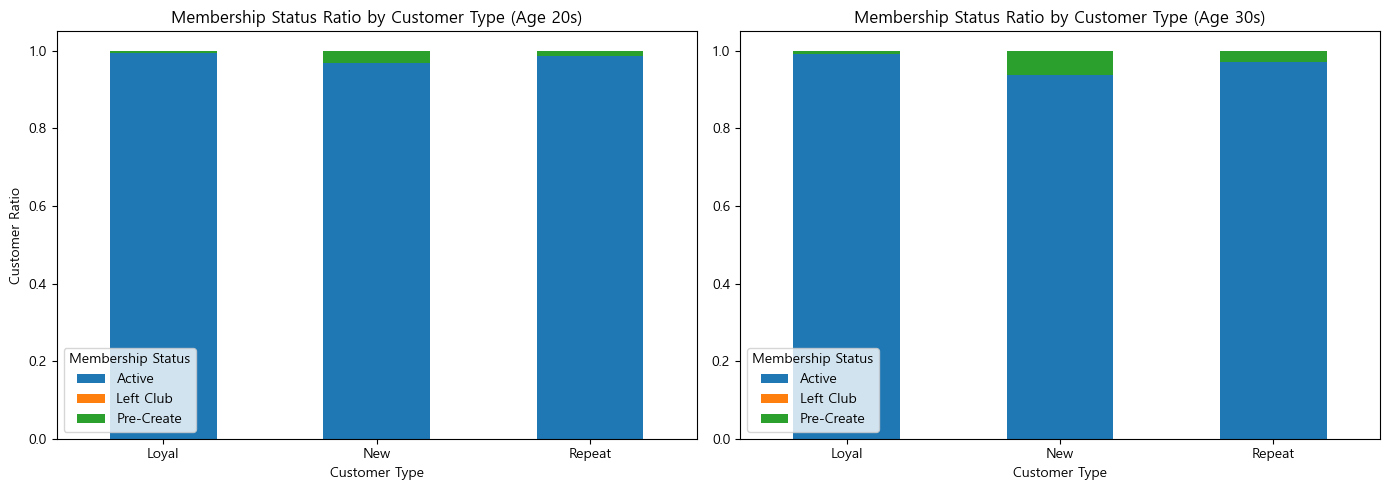

club_member_status         Active  Left Club  Pre-Create
age_group customer_type                                 
20s       Loyal          0.995030   0.000376    0.004594
          New            0.969346   0.000279    0.030375
          Repeat         0.985250   0.000322    0.014428
30s       Loyal          0.990386   0.000534    0.009080
          New            0.937731   0.000429    0.061839
          Repeat         0.970267   0.000402    0.029332

In [52]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
member_20s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Membership Status Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=0)
plt.legend(title="Membership Status")

plt.subplot(1, 2, 2)
member_30s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Membership Status Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.xticks(rotation=0)
plt.legend(title="Membership Status")

plt.tight_layout()
plt.show()

member_pivot

### 고객 타입 X 특정 나이대(20~30대) X 상위20%, 하위20%

In [53]:
revenue_dist = (
    target_2030
    .groupby(["age_group", "customer_type", "revenue_group"])
    .size()
    .reset_index(name="customer_cnt")
)

revenue_dist["ratio"] = (
    revenue_dist["customer_cnt"]
    / revenue_dist
        .groupby(["age_group", "customer_type"])["customer_cnt"]
        .transform("sum")
)

revenue_pivot = (
    revenue_dist
    .pivot(
        index=["age_group", "customer_type"],
        columns="revenue_group",
        values="ratio"
    )
    .fillna(0)
)

revenue_20s = revenue_pivot.loc["20s"]
revenue_30s = revenue_pivot.loc["30s"]


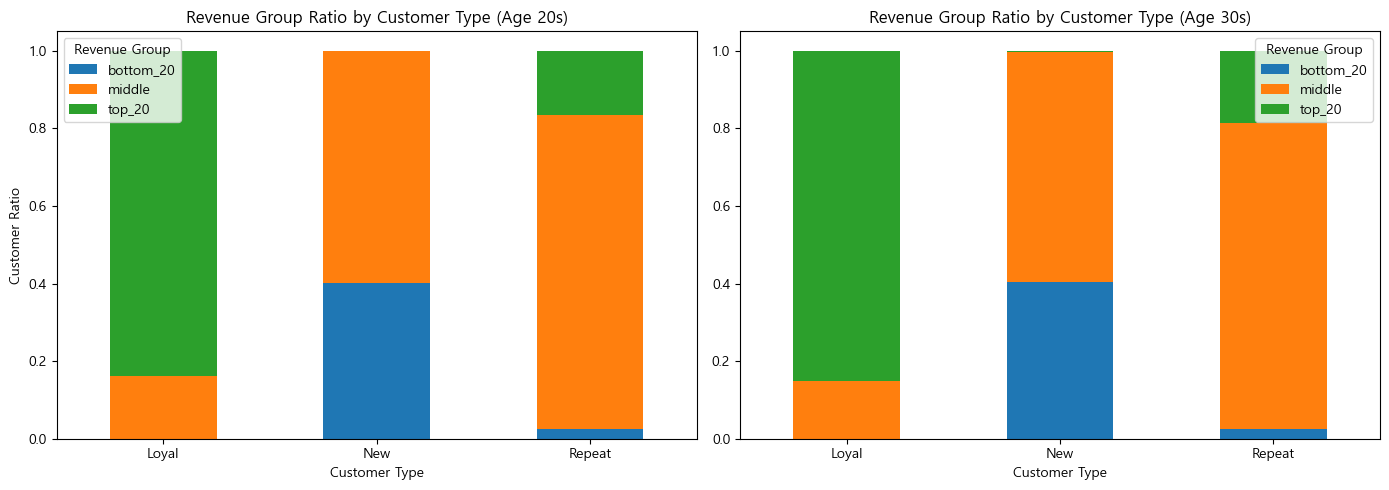

revenue_group            bottom_20    middle    top_20
age_group customer_type                               
20s       Loyal           0.000167  0.161544  0.838289
          New             0.401248  0.597342  0.001410
          Repeat          0.024275  0.809601  0.166124
30s       Loyal           0.000305  0.147871  0.851824
          New             0.403673  0.594080  0.002246
          Repeat          0.024867  0.787982  0.187151

In [54]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
revenue_20s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Revenue Group Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Customer Ratio")
plt.xticks(rotation=0)
plt.legend(title="Revenue Group")

plt.subplot(1, 2, 2)
revenue_30s.plot(kind="bar", stacked=True, ax=plt.gca())
plt.title("Revenue Group Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.xticks(rotation=0)
plt.legend(title="Revenue Group")

plt.tight_layout()
plt.show()

revenue_pivot

### 상품군별 분석

In [55]:
cust_type = customer_summary[
    ["customer_id", 
    "customer_type", 
    "age_group", 
    "FN", 
    "club_member_status", 
    "Active", 
    "revenue_group"]
].copy()

cust_type.isna().sum()

customer_id           0
customer_type         0
age_group             0
FN                    0
club_member_status    0
Active                0
revenue_group         0
dtype: int64

In [56]:
# 거래x상품 테이블 조인
tx_art = (
    analysis_cust[
        ["t_dat", 
        "year_month", 
        "customer_id", 
        "article_id", 
        "revenue", 
        "sales_channel_id"]
    ]
    .merge(
        art,
        on="article_id",
        how="left"
    )
)
tx_art.isna().sum()

t_dat                           0
year_month                      0
customer_id                     0
article_id                      0
revenue                         0
sales_channel_id                0
product_code                    0
prod_name                       0
product_type_info               0
product_group_name              0
graphical_appearance_info       0
perceived_colour_master_info    0
department_info                 0
index_info                      0
index_group_info                0
section_info                    0
garment_group_info              0
dtype: int64

In [57]:
# tx_art_cust + cust_type
tx_art_cust = (
    tx_art
    .merge(
        cust_type,
        on="customer_id",
        how="left"
    )
)

tx_art_cust.shape

(804149, 23)

In [58]:
tx_art_cust.isna().sum()

t_dat                           0
year_month                      0
customer_id                     0
article_id                      0
revenue                         0
sales_channel_id                0
product_code                    0
prod_name                       0
product_type_info               0
product_group_name              0
graphical_appearance_info       0
perceived_colour_master_info    0
department_info                 0
index_info                      0
index_group_info                0
section_info                    0
garment_group_info              0
customer_type                   0
age_group                       0
FN                              0
club_member_status              0
Active                          0
revenue_group                   0
dtype: int64

In [59]:
# 20~30대 나이대 필터링
tx_2030 = tx_art_cust[
    tx_art_cust["age_group"].isin(["20s", "30s"])
].copy()

### 고객 타입 x 20~30대 x product_type_info 상품군

In [60]:
type_dist = (
    tx_2030
    .groupby(["age_group", "customer_type", "product_type_info"])
    .size()
    .reset_index(name="purchase_cnt")
)

type_dist["ratio"] = (
    type_dist["purchase_cnt"]
    / type_dist
        .groupby(["age_group", "customer_type"])["purchase_cnt"]
        .transform("sum")
)

top7_types = (
    type_dist
    .groupby("product_type_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

type_top7 = type_dist[
    type_dist["product_type_info"].isin(top7_types)
].copy()


type_pivot = (
    type_top7
    .pivot(
        index=["age_group", "customer_type"],
        columns="product_type_info",
        values="ratio"
    )
    .fillna(0)
)

type_pivot = type_pivot.loc[
    type_pivot.sum(axis=1).sort_values(ascending=False).index
]

type_20s = type_pivot.loc["20s"]
type_30s = type_pivot.loc["30s"]

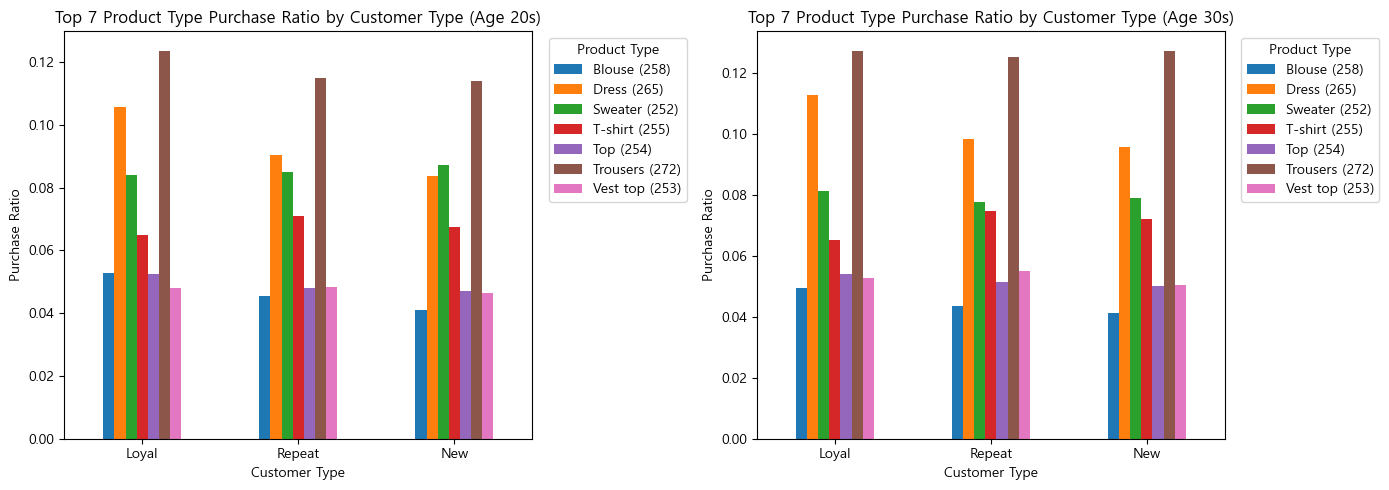

product_type_info        Blouse (258)  Dress (265)  Sweater (252)  \
age_group customer_type                                             
30s       Loyal              0.049671     0.112869       0.081480   
20s       Loyal              0.052755     0.105616       0.083880   
30s       Repeat             0.043722     0.098520       0.077864   
          New                0.041358     0.095963       0.079182   
20s       Repeat             0.045348     0.090429       0.084900   
          New                0.040955     0.083781       0.087327   

product_type_info        T-shirt (255)  Top (254)  Trousers (272)  \
age_group customer_type                                             
30s       Loyal               0.065273   0.053946        0.127359   
20s       Loyal               0.064805   0.052593        0.123617   
30s       Repeat              0.074924   0.051385        0.125379   
          New                 0.072179   0.050013        0.127445   
20s       Repeat              0.070988   0.048151        0.114788   
          New                 0.067533   0.047111        0.114128   

product_type_info        Vest top (253)  
age_group customer_type                  
30s       Loyal                0.052846  
20s       Loyal                0.048039  
30s       Repeat               0.055102  
          New                  0.050410  
20s       Repeat               0.048314  
          New                  0.046385

In [61]:
plt.figure(figsize=(14, 5))

# ===== 20대 =====
plt.subplot(1, 2, 1)

type_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

# ===== 30대 =====
plt.subplot(1, 2, 2)

type_30s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

type_pivot

### 고객 타입 X 특정 나이대(20~30대) X 상품 분류

In [62]:
prod_dist = (
    tx_2030
    .groupby(["age_group", "customer_type", "product_group_name"])
    .size()
    .reset_index(name="purchase_cnt")
)

prod_dist["ratio"] = (
    prod_dist["purchase_cnt"]
    / prod_dist
        .groupby(["age_group", "customer_type"])["purchase_cnt"]
        .transform("sum")
)

top5_products = (
    prod_dist
    .groupby("product_group_name")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

prod_top5 = prod_dist[
    prod_dist["product_group_name"].isin(top5_products)
].copy()

prod_pivot = (
    prod_top5
    .pivot(
        index=["age_group", "customer_type"],
        columns="product_group_name",
        values="ratio"
    )
    .fillna(0)
)

prod_pivot = prod_pivot.loc[
    prod_pivot.sum(axis=1).sort_values(ascending=False).index
]

prod_20s = prod_pivot.loc["20s"]
prod_30s = prod_pivot.loc["30s"]

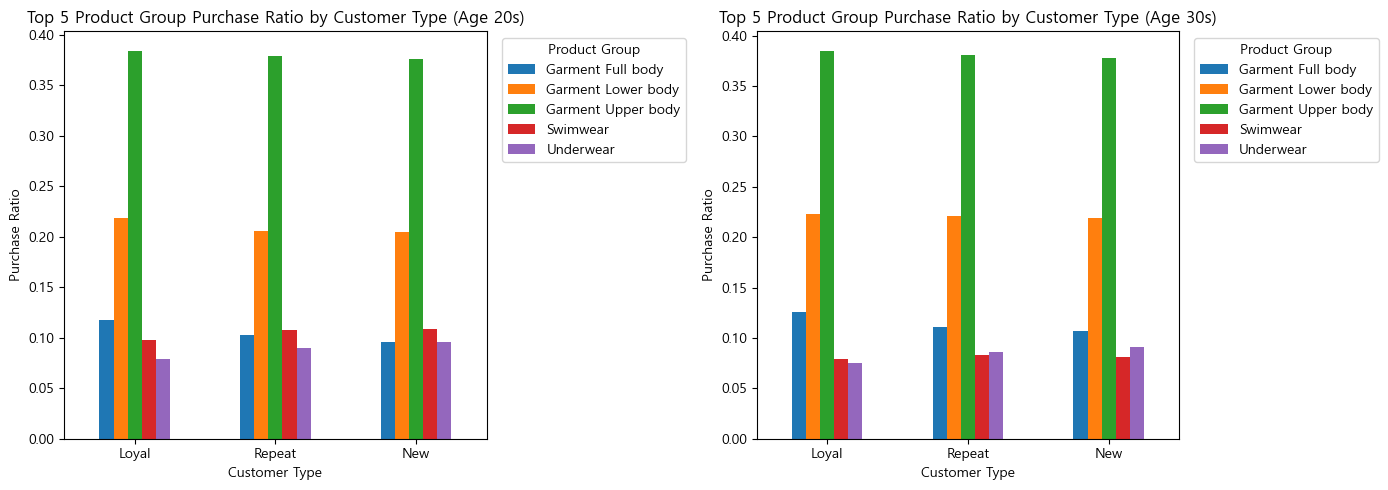

product_group_name       Garment Full body  Garment Lower body  \
age_group customer_type                                          
20s       Loyal                   0.117807            0.218580   
30s       Loyal                   0.125605            0.223404   
20s       Repeat                  0.102389            0.205940   
          New                     0.095884            0.204651   
30s       Repeat                  0.110470            0.220561   
          New                     0.107030            0.219014   

product_group_name       Garment Upper body  Swimwear  Underwear  
age_group customer_type                                           
20s       Loyal                    0.384109  0.097286   0.078571  
30s       Loyal                    0.385080  0.079096   0.075563  
20s       Repeat                   0.379163  0.108039   0.089561  
          New                      0.375815  0.109075   0.096135  
30s       Repeat                   0.380899  0.082967   0.085888  
          New                      0.377841  0.080999   0.091305

In [63]:
plt.figure(figsize=(14, 5))

# ===== 20대 =====
plt.subplot(1, 2, 1)

prod_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 5 Product Group Purchase Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Group", bbox_to_anchor=(1.02, 1), loc="upper left")

# ===== 30대 =====
plt.subplot(1, 2, 2)

prod_30s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 5 Product Group Purchase Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Group", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

prod_pivot

### 고객 타입 x 20~30대 x garment_group_info

In [64]:
garment_dist = (
    tx_2030
    .groupby(["age_group", "customer_type", "garment_group_info"])
    .size()
    .reset_index(name="purchase_cnt")
)

garment_dist["ratio"] = (
    garment_dist["purchase_cnt"]
    / garment_dist
        .groupby(["age_group", "customer_type"])["purchase_cnt"]
        .transform("sum")
)
# top5 선정 
top5_garments = (
    garment_dist
    .groupby("garment_group_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

garment_top5 = garment_dist[
    garment_dist["garment_group_info"].isin(top5_garments)
].copy()


garment_pivot = (
    garment_top5
    .pivot(
        index=["age_group", "customer_type"],
        columns="garment_group_info",
        values="ratio"
    )
    .fillna(0)
)

garment_pivot = garment_pivot.loc[
    garment_pivot.sum(axis=1).sort_values(ascending=False).index
]

garment_20s = garment_pivot.loc["20s"]
garment_30s = garment_pivot.loc["30s"]

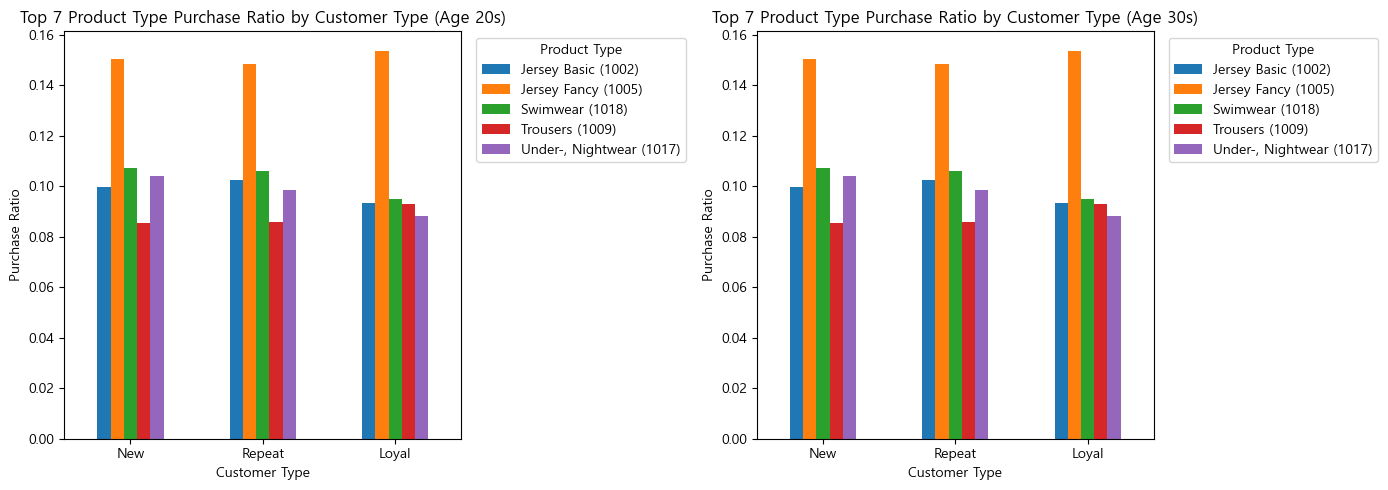

garment_group_info       Jersey Basic (1002)  Jersey Fancy (1005)  \
age_group customer_type                                             
30s       New                       0.102207             0.180662   
          Repeat                    0.105501             0.179135   
20s       New                       0.099569             0.150630   
          Repeat                    0.102493             0.148503   
          Loyal                     0.093488             0.153740   
30s       Loyal                     0.098355             0.173658   

garment_group_info       Swimwear (1018)  Trousers (1009)  \
age_group customer_type                                     
30s       New                   0.078455         0.086317   
          Repeat                0.080615         0.086172   
20s       New                   0.107232         0.085582   
          Repeat                0.106199         0.085769   
          Loyal                 0.095168         0.093114   
30s       Loyal                 0.076391         0.088176   

garment_group_info       Under-, Nightwear (1017)  
age_group customer_type                            
30s       New                            0.104156  
          Repeat                         0.098027  
20s       New                            0.103966  
          Repeat                         0.098460  
          Loyal                          0.088433  
30s       Loyal                          0.087175

In [65]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)

# ===== 20대 =====
plt.subplot(1, 2, 1)

garment_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 20s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

# ===== 30대 =====
plt.subplot(1, 2, 2)

garment_20s.plot(
    kind="bar",
    ax=plt.gca()
)

plt.title("Top 7 Product Type Purchase Ratio by Customer Type (Age 30s)")
plt.xlabel("Customer Type")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=0)
plt.legend(title="Product Type", bbox_to_anchor=(1.02, 1), loc="upper left")

plt.tight_layout()
plt.show()

garment_pivot

# 누적구매 고객 분류 전환시점

## 테이블 생성

In [66]:
# 고객별로 month 순서대로 정렬
monthly_customer = (
    monthly_customer
    .sort_values(["customer_id", "year_month"]))

# 이전 달 customer_type 만들기
monthly_customer["prev_customer_type"] = (
    monthly_customer
    .groupby("customer_id")["customer_type"]
    .shift(1)
)

In [67]:
# 전환 라벨 만들기
# 기본전제: 바뀌지 않음
monthly_customer["transition"] = "No Change"

# 두번 이상 구매해 재구매고객으로 전환
monthly_customer.loc[
    (monthly_customer["prev_customer_type"] == "New") &
    (monthly_customer["customer_type"] == "Repeat"),
    "transition"
] = "New → Repeat"

# 네번 이상 구매해 충성고객으로 전환
monthly_customer.loc[
    (monthly_customer["prev_customer_type"] == "Repeat") &
    (monthly_customer["customer_type"] == "Loyal"),
    "transition"
] = "Repeat → Loyal"

In [68]:
# 전환 발생일 저장
transition_events =(
    monthly_customer[
        monthly_customer["transition"]
        .isin(["New → Repeat", "Repeat → Loyal"])
    ]
    .copy())

transition_events.head()

,year_month,customer_id,transaction_cnt,customer_type,prev_customer_type,transition
432959,2019-09,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,2,Repeat,New,New → Repeat
320636,2019-07,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,5,Loyal,Repeat,Repeat → Loyal
251506,2019-06,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,4,Loyal,Repeat,Repeat → Loyal
91915,2019-03,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,8,Loyal,Repeat,Repeat → Loyal
386161,2019-08,00023e3dd8618bc63ccad995a5ac62e21177338d642d66...,4,Loyal,Repeat,Repeat → Loyal


## 월별 누적구매 고객 분류 전환시점

In [69]:
# 고객별 첫 전환 월 저장
# 각 고객이 언제 처음으로 전환되었는지 저장

#  New → Repeat 전환이 '처음' 발생한 월
nr_month = (
    transition_events[transition_events["transition"] == "New → Repeat"]
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="nr_month")
)

# Repeat → Loyal 전환이 '처음' 발생한 월
rl_month = (
    transition_events[transition_events["transition"] == "Repeat → Loyal"]
    .groupby("customer_id")["year_month"]
    .min()
    .reset_index(name="rl_month")
)

# 고객 단위 전환 시점 테이블 생성
# outer join
#   New → Repeat만 하고 Loyal까지 가지 않은 고객
#   Repeat → Loyal만 관측된 고객
#   모두 보존
customer_transition_point = (
    nr_month
    .merge(
        rl_month, 
        on="customer_id", 
        how="outer")
)

customer_transition_point.info()

<class 'pandas.DataFrame'>
RangeIndex: 122821 entries, 0 to 122820
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   customer_id  122821 non-null  str  
 1   nr_month     101676 non-null  str  
 2   rl_month     48636 non-null   str  
dtypes: str(3)
memory usage: 2.8 MB


In [70]:
transition_events.shape

(150312, 6)

In [71]:
customer_transition_point.shape

(122821, 3)

In [72]:
customer_cnt = tx["customer_id"].nunique()
customer_cnt

351503

- customer_cnt == 거래 기록이 한 번이라도 있는 모든 고객의 수
- transition_events == 전환 ‘사건(event)’의 개수
- customer_transition_point == 고객별 ‘전환 지점’을 기록한 테이블

전환 이밴트 수 > 전환된 고객 수<br>
즉 전환을 2번 한 고객이 존재한다는 의미

구매이력이 존재하는 고객: 351,503<br>
누적구매등급 전환이 한번이라도 발생한 고객: 122,821<br>
전체 고객 중 약 35%만 최소 한 번이라도 재구매 단계로 진입

In [73]:
customer_transition_point.isna().sum()
# 의도한 결측치
# nr_month: Repeat으로 전환되지 않은 고객 21,145명
# rl_month: Loyal으로 전환되지 않은 고객 74,185명

customer_id        0
nr_month       21145
rl_month       74185
dtype: int64

In [74]:
# 전환 이벤트 발생 월별 고객 수 집계

# 고객 유형이 변한 경우만 기록
# 같은 월에 같은 고객이 여러 전환 이벤트를 일으켜도 고객 수는 1명
transition_monthly_cnt = (
    transition_events
    .groupby(["year_month", "transition"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
    .sort_values(["year_month", "transition"])
)


# 그래프용 pivot 
transition_monthly_pivot = (
    transition_monthly_cnt
    .pivot(
        index="year_month"
        , columns="transition"
        , values="customer_cnt")
    .fillna(0)
    .sort_index()
)

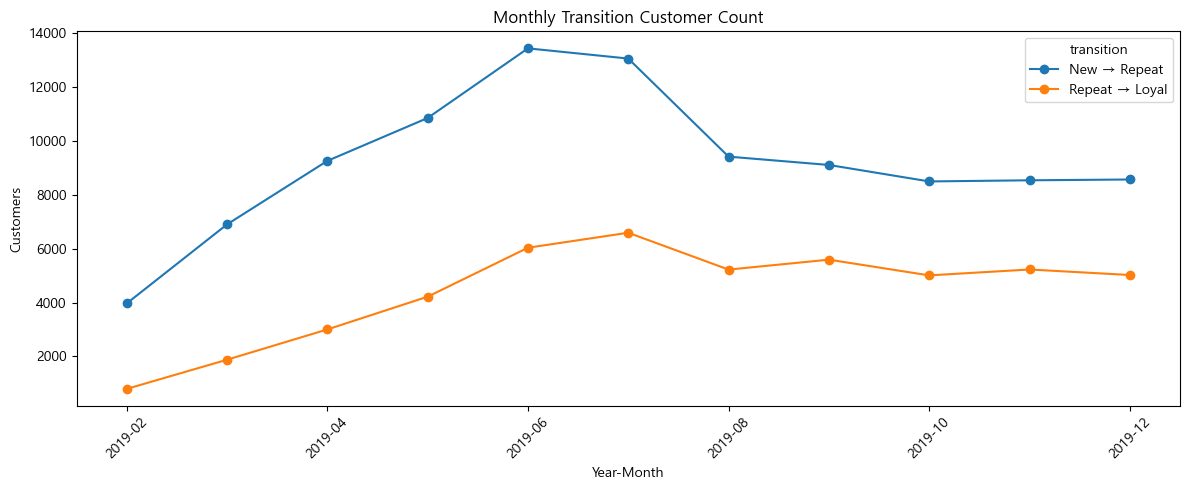

transition,New → Repeat,Repeat → Loyal
year_month,,
2019-02,3970,796
2019-03,6906,1880
2019-04,9266,3005
2019-05,10859,4221
2019-06,13446,6040
2019-07,13067,6597
2019-08,9424,5228
2019-09,9115,5597
2019-10,8503,5013


In [75]:
transition_monthly_pivot.plot(kind="line", marker="o", figsize=(12, 5))
plt.title("Monthly Transition Customer Count")
plt.xlabel("Year-Month")
plt.ylabel("Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
transition_monthly_pivot

New → Repeat
- 2월~6월까지 빠른 증가율 
    - 약 4천 → 약 1.3만 수준으로 증가
- 7월 이후 감소 및 정체
    - 6월 정점 이후 8월에 급락
    - 하반기에는 8.5천 내외로 안정화

Repeat → Loyal
- 2월~7월까지 꾸준한 증가
    - 약 800 → 약 6,500 수준으로 증가
- 8월 이후 완만한 하락/정체
    - 5천 초반에서 안정화된 상태

> New → Repeat 전환의 정점(6월) 이후 약 1개월 뒤, Repeat→Loyal 전환이 정점(7월)을 기록했습니다.<br>

## 누적구매율 전환시점에서 확인하는 나이대별 차이

In [76]:
# 고객 속성 테이블 구성 (고객 단위)

# 고객 나이대 정보만 추출
cust_attr = (
    analysis_cust[
        ["customer_id"
        , "age_group"
        , "fn"
        , "active"
        , "club_member_status"]
    ]
    .drop_duplicates("customer_id")
    .copy()
)

# 전환 이벤트에 나이대 붙이기
# 고객 속성이 없을수도 있기 때문에 left
transition_events_age = (
    transition_events
    .merge(
    cust_attr
    , on="customer_id"
    , how="left"
))
transition_events_age.shape

(150312, 10)

In [77]:
transition_age_month_cnt = (
    transition_events_age
    .groupby(
        ["year_month"
        , "age_group"
        , "transition"]
        , as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
    .sort_values(["year_month", "age_group"])
)

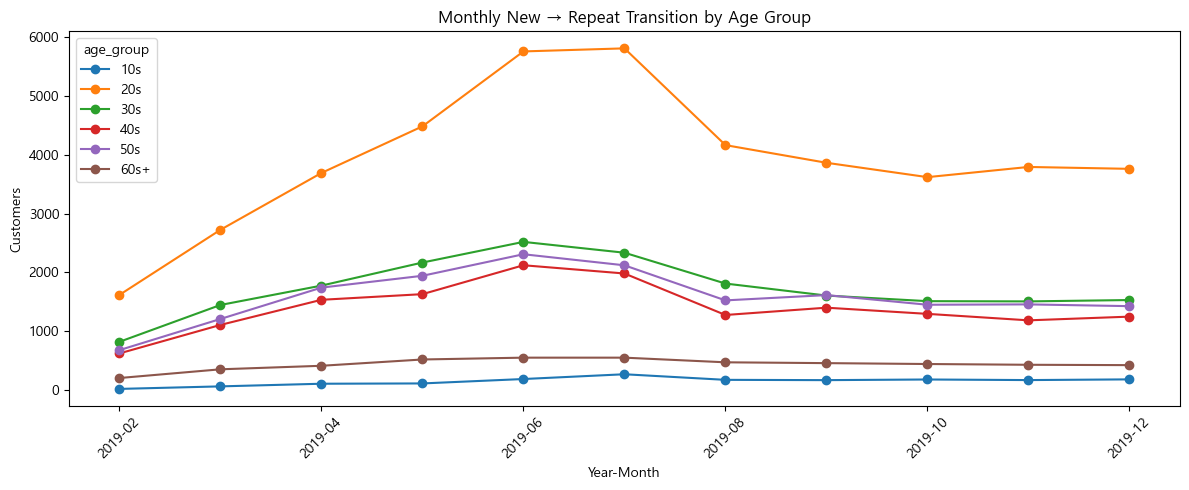

In [78]:
# 최초 재구매 전환
nr_age = transition_age_month_cnt[
    transition_age_month_cnt["transition"] == "New → Repeat"
]

# 그래프용 피봇 테이블
nr_age_pivot = (
    nr_age
    .pivot(index="year_month", columns="age_group", values="customer_cnt")
    .fillna(0)
    .sort_index()
)

nr_age_pivot.plot(kind="line", marker="o", figsize=(12, 5))
plt.title("Monthly New → Repeat Transition by Age Group")
plt.xlabel("Year-Month")
plt.ylabel("Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

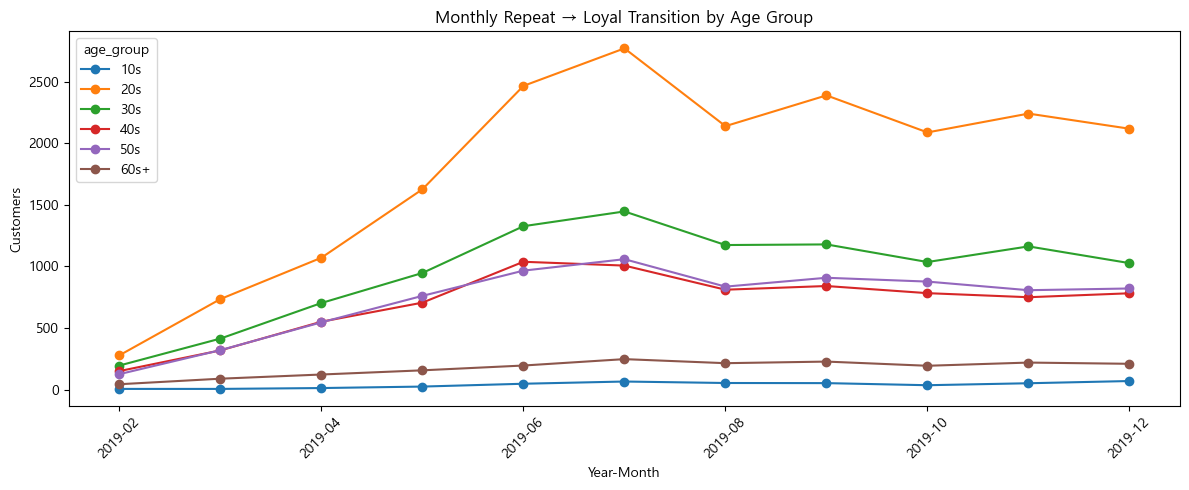

In [79]:
# 최초 충성 전환
rl_age = transition_age_month_cnt[
    transition_age_month_cnt["transition"] == "Repeat → Loyal"
]

rl_age_pivot = (
    rl_age
    .pivot(index="year_month", columns="age_group", values="customer_cnt")
    .fillna(0)
    .sort_index()
)

rl_age_pivot.plot(kind="line", marker="o", figsize=(12, 5))
plt.title("Monthly Repeat → Loyal Transition by Age Group")
plt.xlabel("Year-Month")
plt.ylabel("Customers")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

신규→재구매(New→Repeat) 전환 나이대 분석
- 전환 규모는 20대가 압도적으로 나타나고 있습니다.
    - 6~7월 피크: 약 5,700~5,800명
    - 30대는 그 다음(약 2,500명 수준)
    - 40·50대는 비슷한 중간 규모
    - 10대·60대는 매우 작음
> 신규 유입 → 첫 재구매는 ‘젊은 연령대’가 거의 전부를 만든다 판단 가능합니다.

특이사항
- 모든 연령대가 같은 타이밍에 움직인다
    - 모든 나이대가 2월→6~7월 증가
    - 8월에 동시에 하락 후 완만한 정체
> 특정 연령대만의 작용이 아닌 전체 시장/시즌 영향이라 추측 가능

재구매→충성(Repeat → Loyal) 전환 나이대 분석
- 20대가 여전히 가장 크지만 30대, 40대, 50대의 상대적 비중이 커지고 있다.
- New→Repeat보다 연령 분산이 훨씬 크게 측정된다.
> 충성층 전환은 반드시 젊은 층한테만 발생하는 것은 아니다.

특히 30대는, 유입은 적지만 충성으로 갈 확률이 높은 집단일 가능성이 크다

## 누적구매율과 비중으로 확인하는 고객 속성 분석


목표:<br>
누적 관점에서 고객을
- 신규 고객
- 재구매 고객
- 충성 고객

으로 분류하고, <br>
각 그룹이 어떤 고객 속성(age_group, FN, 멤버십 등)을 가지는지를 비중 중심으로 분석한다.

### 전환 시점 고객 속성 분석 테이블 생성

In [80]:
rev.info()

<class 'pandas.DataFrame'>
RangeIndex: 1037772 entries, 0 to 1037771
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1037772 non-null  datetime64[us]
 1   customer_id       1037772 non-null  str           
 2   article_id        1037772 non-null  int64         
 3   revenue           1037772 non-null  float64       
 4   sales_channel_id  1037772 non-null  int64         
 5   month             1037772 non-null  int64         
 6   year_month        1037772 non-null  str           
 7   month_day         1037772 non-null  str           
 8   total_revenue     1037772 non-null  float64       
 9   revenue_group     1037772 non-null  str           
dtypes: datetime64[us](1), float64(2), int64(3), str(4)
memory usage: 79.2 MB


In [81]:
rev_attr = (
    rev[["customer_id", "revenue_group"]]
    .drop_duplicates("customer_id")
    .copy()
)
rev_attr.shape

(455812, 2)

In [82]:
# 전환 이벤트에 고객 속성 + 매출 속성 결합

transition_attr = (
    transition_events
    # 고객 속성 병합 (연령대, 멤버십, 활동 여부 등)
    .merge(cust_attr, on="customer_id", how="left")
    # 고객 매출/가치 속성 병합 (고객 등급, 누적 매출 등)
    .merge(rev_attr, on="customer_id", how="left")
)

# 20대 전환 고객만 추출
transition_attr_20s = transition_attr[
    transition_attr["age_group"] == "20s"
].copy()

# 30대 전환 고객만 추출
transition_attr_30s = transition_attr[
    transition_attr["age_group"] == "30s"
].copy()

transition_attr_20s.shape, transition_attr_30s.shape

((63203, 11), (29647, 11))

### 전환 시점 FN 상태

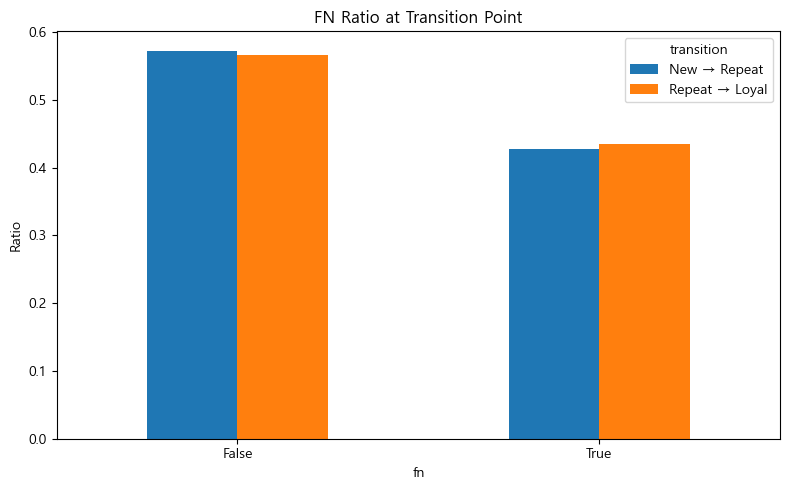

transition,New → Repeat,Repeat → Loyal
fn,,
False,0.572412,0.565429
True,0.427588,0.434571


In [83]:
# 같은 전환유형 내에서
# FN구독고객 / 비구독 고객(20대)이 각각 몇 명인지 계산
# nunique 로 1고객 == 1행

fn_20s = (
    transition_attr_20s
    .groupby(["transition", "fn"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 전환 비중 계산
fn_20s["ratio"] = (
    fn_20s["customer_cnt"]
    / fn_20s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇테이블
fn_pivot = (
    fn_20s
    .pivot(index="fn", columns="transition", values="ratio")
    .fillna(0)
)

fn_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("FN Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

fn_pivot

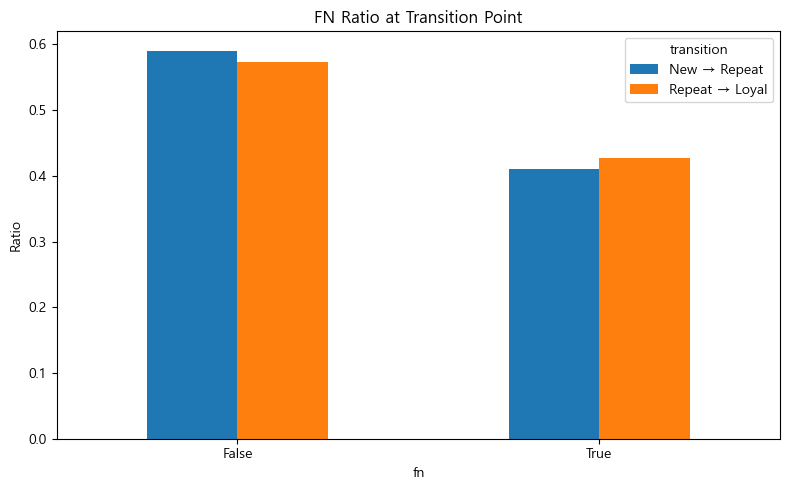

transition,New → Repeat,Repeat → Loyal
fn,,
False,0.590229,0.572559
True,0.409771,0.427441


In [84]:
# 같은 전환유형 내에서
# FN구독고객 / 비구독 고객(30대)이 각각 몇 명인지 계산
# nunique 로 1고객 == 1행

fn_30s = (
    transition_attr_30s
    .groupby(["transition", "fn"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

fn_30s["ratio"] = (
    fn_30s["customer_cnt"]
    / fn_30s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇테이블
fn_pivot = (
    fn_30s
    .pivot(index="fn", columns="transition", values="ratio")
    .fillna(0)
)

fn_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("FN Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

fn_pivot

20대 분석
- New → Repeat: 약 42.8%
- Repeat → Loyal: 약 43.5%
> 전환 단계가 바뀌어도 FN 비중이 거의 변함 없음<br>
FN을 구독하든 안 하든 전환 확률 자체가 크게 달라지지 않는 구조로 파악된다.

30대 분석
- New → Repeat 단계: FN 비율 41.0%
- Repeat → Loyal 단계: FN 비율 42.7% (약간의 증가폭)
> FN이 초기 재구매 유도에는 큰 영향 없다로 파악 <br>
하지만 충성 고객으로 가는 단계에서는 약한 긍정 신호를 보인다.

> 20대 30대 모두 Fn의 여부가 전환 촉진 장치로써 작용하긴 어려울것으로 판단된다.

### 전환 시점 Active

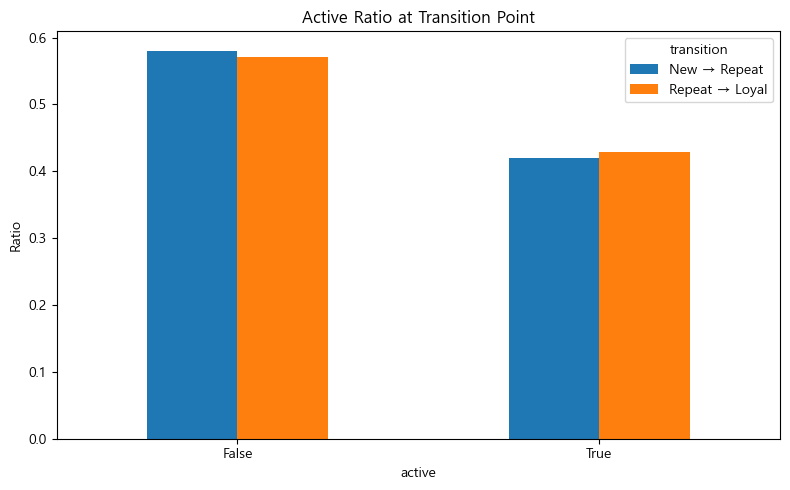

transition,New → Repeat,Repeat → Loyal
active,,
False,0.580269,0.57145
True,0.419731,0.42855


In [85]:
# 20대 활동 고객 여부
active_20s = (
    transition_attr_20s
    .groupby(["transition", "active"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 20대 활동 고객 여부 비율
active_20s["ratio"] = (
    active_20s["customer_cnt"]
    / active_20s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
active_pivot = (
    active_20s
    .pivot(index="active", columns="transition", values="ratio")
    .fillna(0)
)

active_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("Active Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

active_pivot

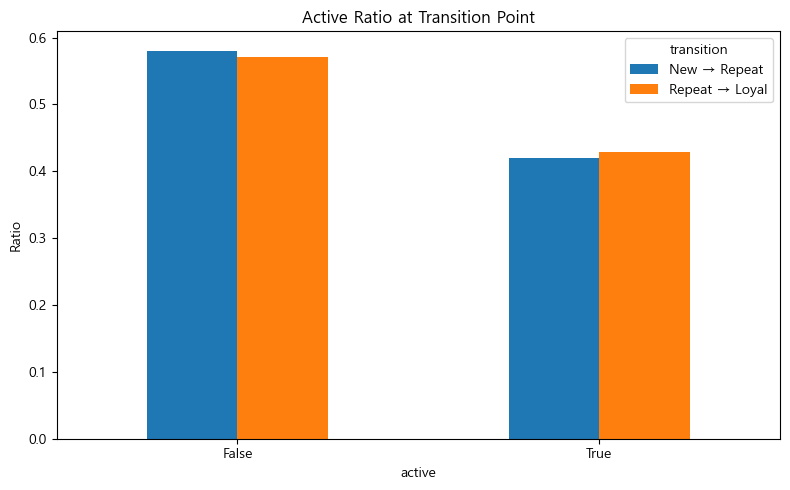

transition,New → Repeat,Repeat → Loyal
active,,
False,0.580269,0.57145
True,0.419731,0.42855


In [86]:
# 30대 활동 고객 여부
active_30s = (
    transition_attr_30s
    .groupby(["transition", "active"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 30대 활동 고객 여부 비중
active_30s["ratio"] = (
    active_30s["customer_cnt"]
    / active_30s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
active_pivot = (
    active_20s
    .pivot(index="active", columns="transition", values="ratio")
    .fillna(0)
)

active_pivot.plot(kind="bar", figsize=(8, 5))
plt.title("Active Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

active_pivot

20대~30대 활동 고객 여부와 전환율
- 두 전환 모두에서 Active = False가 다수
- Repeat → Loyal 단계에서 Active 비중이 소폭 증가 (41.97% → 42.86%)
> 전환 단계가 깊어질수록 활동 고객 비중이 커짐 이는 30대 일수록 경향이 강해집니다.

> 재구매를 시작하게 만드는 조건보다 충성 고객으로 굳어지는 과정에서 중요해지는 상태 변수로 파악됩니다.

### 전환 시점 맴버십

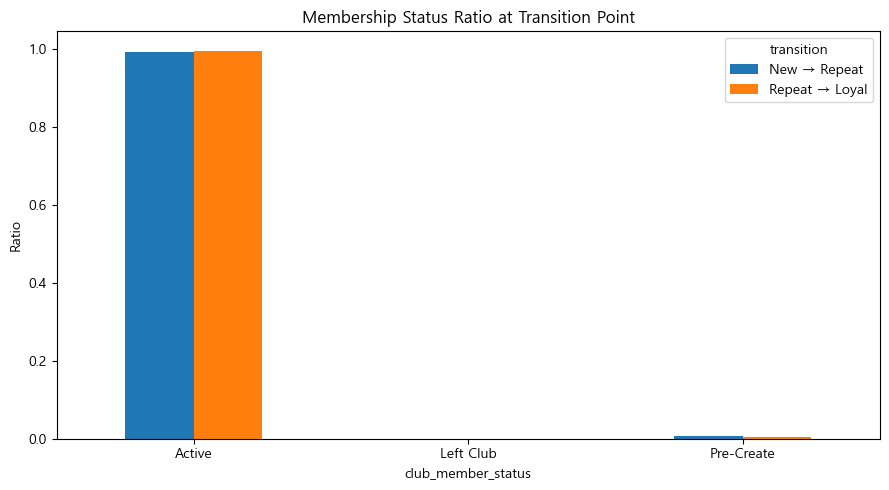

transition,New → Repeat,Repeat → Loyal
club_member_status,,
Active,0.992859,0.996086
Left Club,0.000324,0.000452
Pre-Create,0.006817,0.003462


In [87]:
# 20 전환 시점 맴버십
member_20s = (
    transition_attr_20s
    .groupby(["transition", "club_member_status"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 20 전환 시점 맴버십 비중
member_20s["ratio"] = (
    member_20s["customer_cnt"]
    / member_20s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
member_pivot = (
    member_20s
    .pivot(index="club_member_status", columns="transition", values="ratio")
    .fillna(0)
)

member_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Membership Status Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

member_pivot

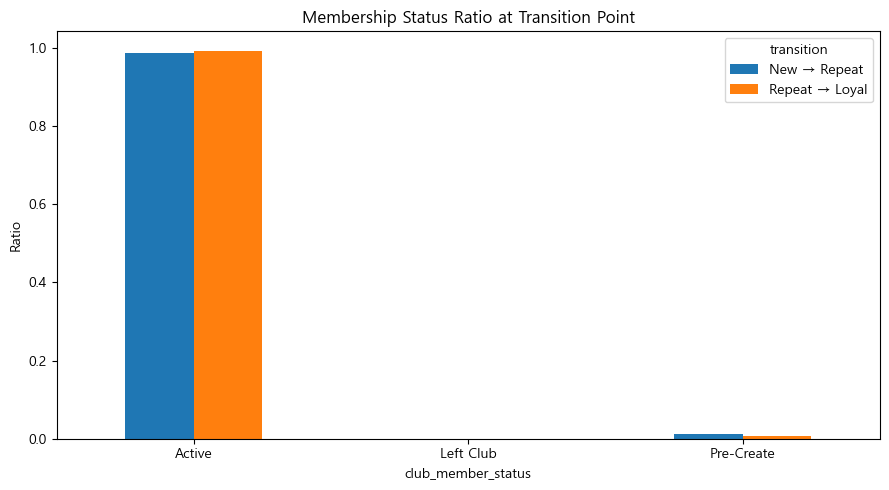

transition,New → Repeat,Repeat → Loyal
club_member_status,,
Active,0.987182,0.993215
Left Club,0.000473,0.000565
Pre-Create,0.012346,0.006219


In [88]:
# 30 전환 시점 맴버십
member_30s = (
    transition_attr_30s
    .groupby(["transition", "club_member_status"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

# 30 전환 시점 맴버십 비중
member_30s["ratio"] = (
    member_30s["customer_cnt"]
    / member_30s.groupby("transition")["customer_cnt"].transform("sum")
)

# 그래프용 피봇
member_pivot = (
    member_30s
    .pivot(index="club_member_status", columns="transition", values="ratio")
    .fillna(0)
)

member_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Membership Status Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

member_pivot

- 20~30대 분석
    - 전환(New → Repeat, Repeat → Loyal)은 사실상 "클럽 Active 회원" 안에서만 발생
    - 멤버십 상태는 "전환에 영향을 주는 변수"가 아니라 전환이 발생하기 위한 전제 조건이라 추측 가능하다.

### 전환시점 상위 하위 20%

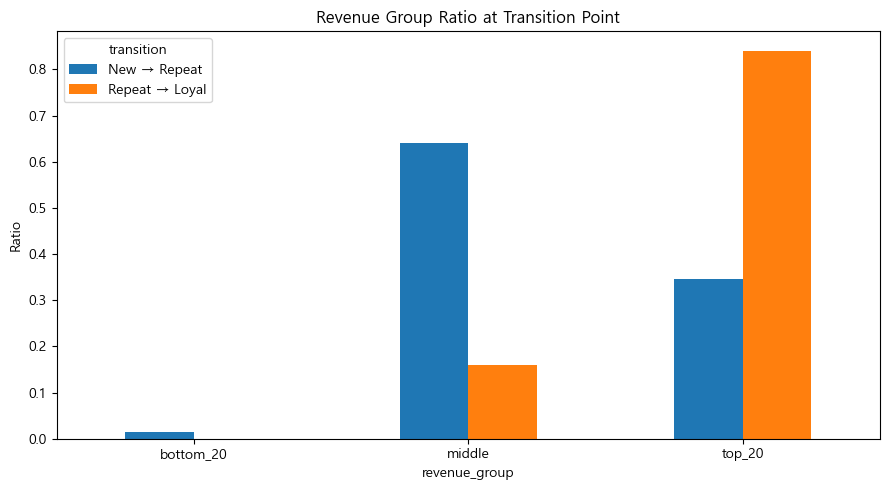

transition,New → Repeat,Repeat → Loyal
revenue_group,,
bottom_20,0.014050,0.000100
middle,0.640977,0.159609
top_20,0.344973,0.840291


In [89]:
revenue_20s = (
    transition_attr_20s
    .groupby(["transition", "revenue_group"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

revenue_20s["ratio"] = (
    revenue_20s["customer_cnt"]
    / revenue_20s.groupby("transition")["customer_cnt"].transform("sum")
)

revenue_pivot = (
    revenue_20s
    .pivot(index="revenue_group", columns="transition", values="ratio")
    .fillna(0)
)

revenue_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Revenue Group Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

revenue_pivot

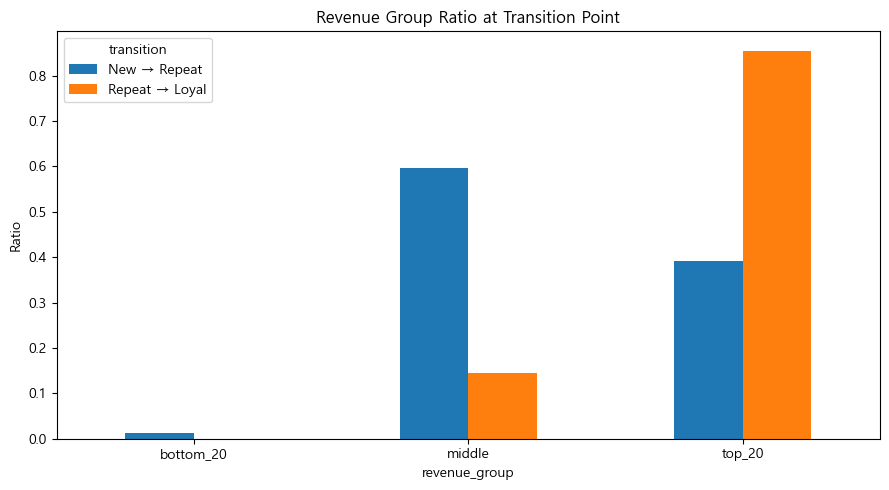

transition,New → Repeat,Repeat → Loyal
revenue_group,,
bottom_20,0.012030,0.000188
middle,0.596323,0.144930
top_20,0.391647,0.854881


In [90]:
revenue_30s = (
    transition_attr_30s
    .groupby(["transition", "revenue_group"], as_index=False)
    .agg(customer_cnt=("customer_id", "nunique"))
)

revenue_30s["ratio"] = (
    revenue_30s["customer_cnt"]
    / revenue_30s.groupby("transition")["customer_cnt"].transform("sum")
)

revenue_pivot = (
    revenue_30s
    .pivot(index="revenue_group", columns="transition", values="ratio")
    .fillna(0)
)

revenue_pivot.plot(kind="bar", figsize=(9, 5))
plt.title("Revenue Group Ratio at Transition Point")
plt.ylabel("Ratio")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

revenue_pivot

## 상품군별 분석

In [91]:
# 전환 시점의 거래만 추출
transition_tx_art = (
    rev
    .merge(
        transition_events,
        on=["customer_id", "year_month"],
        how="inner"
    )
    .merge(
        art,
        on="article_id",
        how="left"
    )
)

transition_tx_art_age = transition_tx_art.merge(
    cust[["customer_id", "age_group"]],
    on="customer_id",
    how="left"
)

transition_tx_art_20s = transition_tx_art_age[
    transition_tx_art_age["age_group"] == "20s"
].copy()

transition_tx_art_30s = transition_tx_art_age[
    transition_tx_art_age["age_group"] == "30s"
].copy()

transition_tx_art_age.shape

(202425, 26)

전환 이벤트 테이블은 고객의 상태 변화 발생 시점을 기준으로 구성되어 있으며,<br>
상품군 분석을 위해 전환이 발생한 월의 거래 데이터를 결합함에 따라<br>
하나의 전환 이벤트에 여러 상품 구매가 매핑되어 행 수가 증가하였다.

### 전환시점 상품군 분석 (의류 대분류)
- product_group_name

In [92]:
pg_20 = (
    transition_tx_art_20s
    .groupby(["transition", "product_group_name"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pg_20["ratio"] = (
    pg_20["purchase_cnt"]
    / pg_20.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pg = (
    pg_20
    .groupby("product_group_name")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pg_top7 = pg_20[
    pg_20["product_group_name"].isin(top7_pg)
].copy()

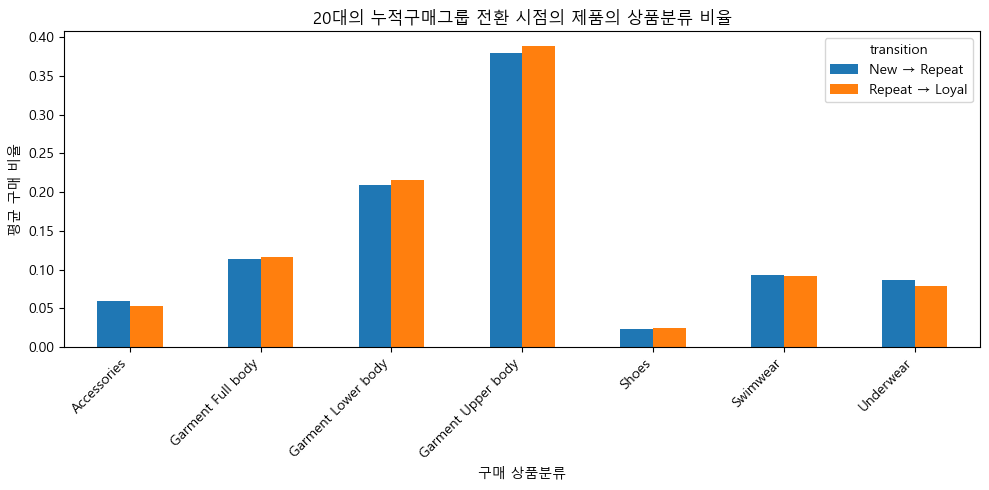

transition,New → Repeat,Repeat → Loyal
product_group_name,,
Accessories,0.059621,0.053560
Garment Full body,0.113195,0.116945
Garment Lower body,0.209864,0.215918
Garment Upper body,0.379508,0.388276
Shoes,0.023714,0.024677
Swimwear,0.092966,0.092091
Underwear,0.086762,0.078326


In [93]:
pg_pivot = (
    pg_top7
    .pivot(
        index="product_group_name",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("20대의 누적구매그룹 전환 시점의 제품의 상품분류 비율")
plt.xlabel("구매 상품분류")
plt.ylabel("평균 구매 비율")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
pg_pivot

In [94]:
pg_30 = (
    transition_tx_art_30s
    .groupby(["transition", "product_group_name"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pg_30["ratio"] = (
    pg_30["purchase_cnt"]
    / pg_30.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pg = (
    pg_30
    .groupby("product_group_name")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pg_top7 = pg_30[
    pg_30["product_group_name"].isin(top7_pg)
].copy()


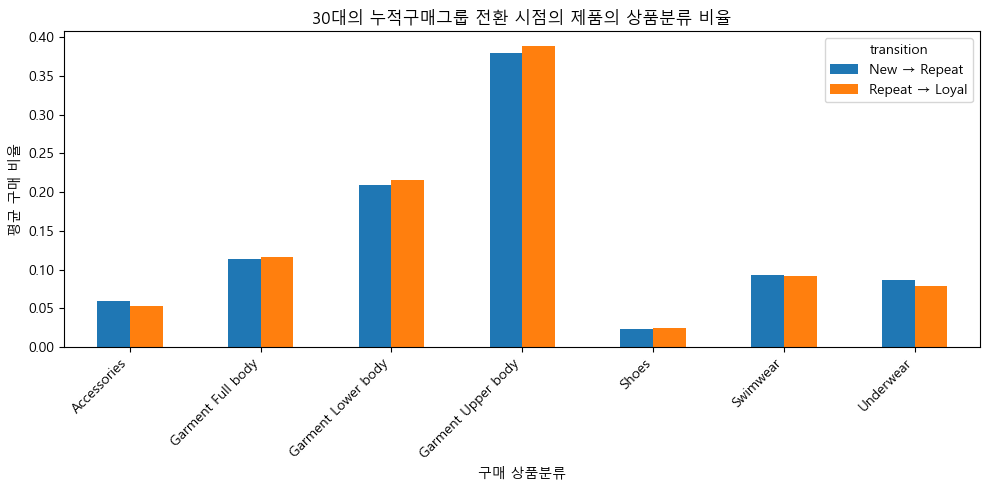

transition,New → Repeat,Repeat → Loyal
product_group_name,,
Accessories,0.059621,0.053560
Garment Full body,0.113195,0.116945
Garment Lower body,0.209864,0.215918
Garment Upper body,0.379508,0.388276
Shoes,0.023714,0.024677
Swimwear,0.092966,0.092091
Underwear,0.086762,0.078326


In [95]:
pg_30 = (
    pg_top7
    .pivot(
        index="product_group_name",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("30대의 누적구매그룹 전환 시점의 제품의 상품분류 비율")
plt.xlabel("구매 상품분류")
plt.ylabel("평균 구매 비율")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
pg_pivot

### 상품군 분석 2 (중뷴류: 제품 타입)
- product_type_info

In [96]:
pt_20s = (
    transition_tx_art_20s
    .groupby(["transition", "product_type_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pt_20s["ratio"] = (
    pt_20s["purchase_cnt"]
    / pt_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pt = (
    pt_20s
    .groupby("product_type_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pt_top7 = pt_20s[
    pt_20s["product_type_info"].isin(top7_pt)
].copy()

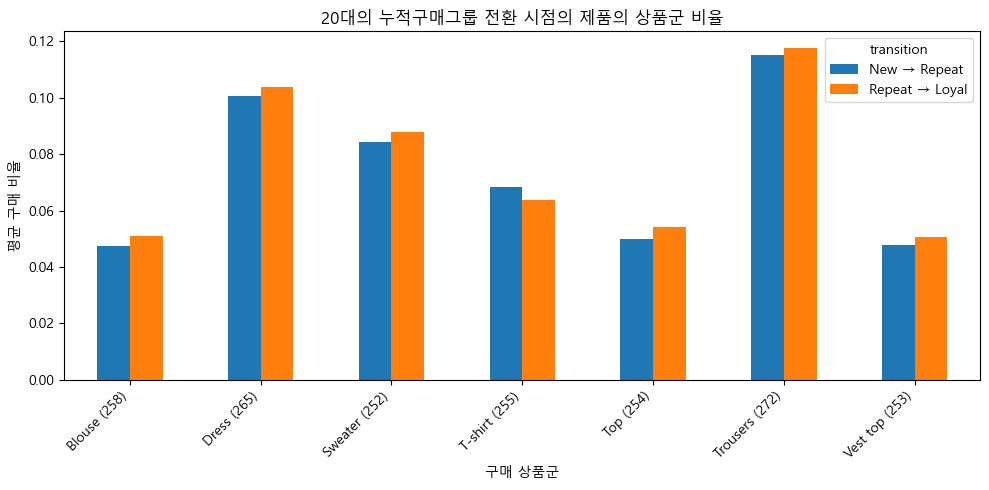

transition,New → Repeat,Repeat → Loyal
product_type_info,,
Blouse (258),0.047547,0.050943
Dress (265),0.100392,0.103885
Sweater (252),0.084438,0.087885
T-shirt (255),0.068228,0.063620
Top (254),0.049910,0.054060
Trousers (272),0.115263,0.117592
Vest top (253),0.047921,0.050501


In [97]:
pt_pivot = (
    pt_top7
    .pivot(
        index="product_type_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pt_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("20대의 누적구매그룹 전환 시점의 제품의 상품군 비율")
plt.xlabel("구매 상품군")
plt.ylabel("평균 구매 비율")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pt_pivot

In [98]:
pt_30s = (
    transition_tx_art_30s
    .groupby(["transition", "product_type_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

pt_30s["ratio"] = (
    pt_30s["purchase_cnt"]
    / pt_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

top7_pt = (
    pt_30s
    .groupby("product_type_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pt_top7 = pt_30s[
    pt_30s["product_type_info"].isin(top7_pt)
].copy()

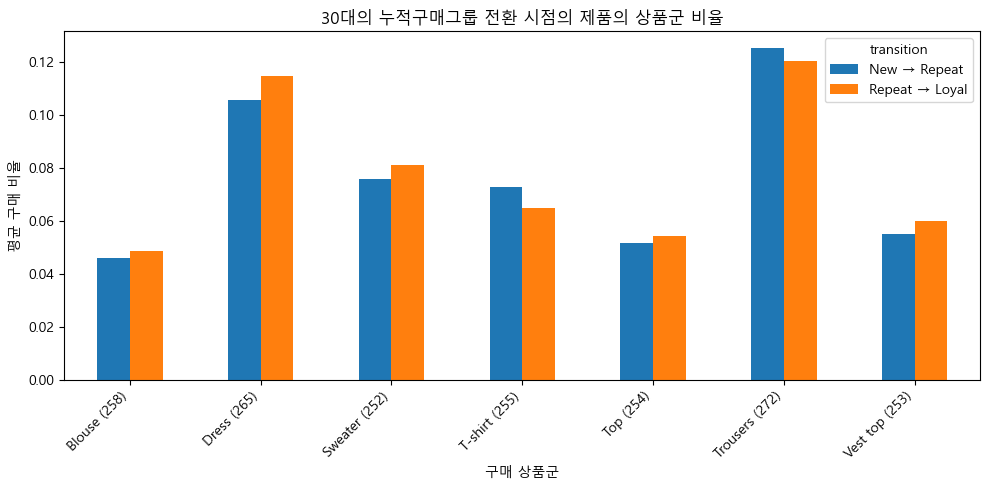

transition,New → Repeat,Repeat → Loyal
product_type_info,,
Blouse (258),0.045949,0.048717
Dress (265),0.105497,0.114734
Sweater (252),0.075701,0.080836
T-shirt (255),0.072576,0.064885
Top (254),0.051450,0.054214
Trousers (272),0.125127,0.120285
Vest top (253),0.054883,0.060034


In [99]:
pt_pivot = (
    pt_top7
    .pivot(
        index="product_type_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

pt_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("30대의 누적구매그룹 전환 시점의 제품의 상품군 비율")
plt.xlabel("구매 상품군")
plt.ylabel("평균 구매 비율")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pt_pivot

### 상품군 분석 3 (의류 형태)
- garment_group_info

In [100]:
gg_20s = (
    transition_tx_art_20s
    .groupby(["transition", "garment_group_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

gg_20s["ratio"] = (
    gg_20s["purchase_cnt"]
    / gg_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

top5_gg = (
    gg_20s
    .groupby("garment_group_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

gg_top5 = gg_20s[
    gg_20s["garment_group_info"].isin(top5_gg)
].copy()


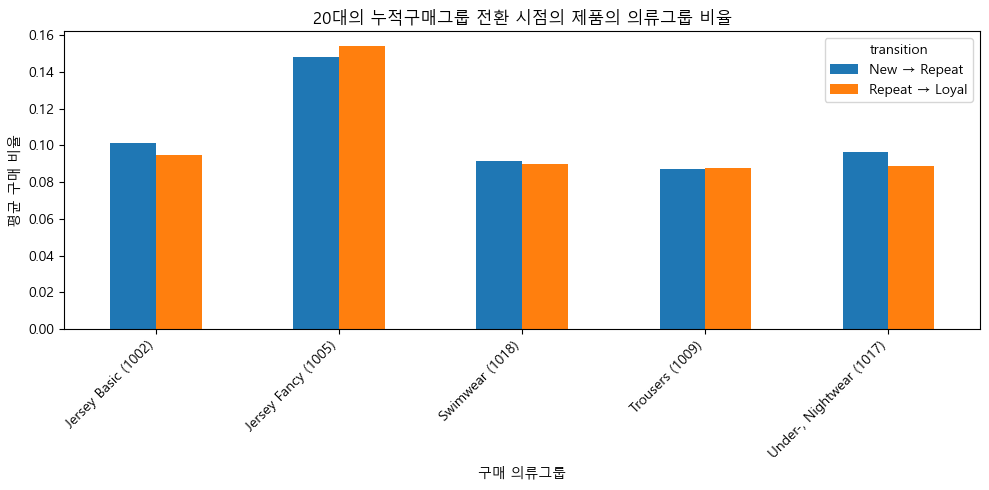

transition,New → Repeat,Repeat → Loyal
garment_group_info,,
Jersey Basic (1002),0.101554,0.094915
Jersey Fancy (1005),0.147821,0.154328
Swimwear (1018),0.091548,0.090061
Trousers (1009),0.087195,0.087856
"Under-, Nightwear (1017)",0.096571,0.088650


In [101]:
gg_pivot = (
    gg_top5
    .pivot(
        index="garment_group_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

gg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("20대의 누적구매그룹 전환 시점의 제품의 의류그룹 비율")
plt.xlabel("구매 의류그룹")
plt.ylabel("평균 구매 비율")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

gg_pivot

In [102]:
gg_30s = (
    transition_tx_art_30s
    .groupby(["transition", "garment_group_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

gg_30s["ratio"] = (
    gg_30s["purchase_cnt"]
    / gg_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

top5_gg = (
    gg_30s
    .groupby("garment_group_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

gg_top5 = gg_30s[
    gg_30s["garment_group_info"].isin(top5_gg)
].copy()


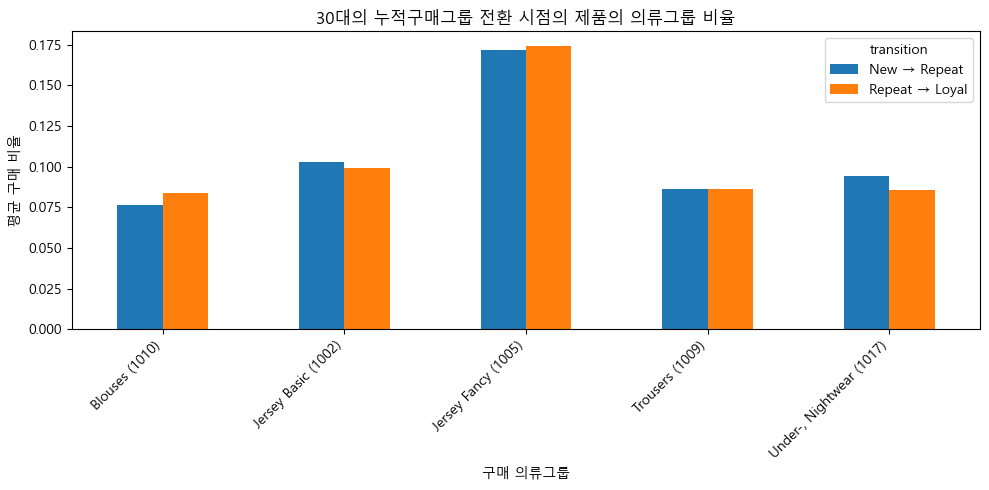

transition,New → Repeat,Repeat → Loyal
garment_group_info,,
Blouses (1010),0.076405,0.083800
Jersey Basic (1002),0.102768,0.098836
Jersey Fancy (1005),0.171383,0.174445
Trousers (1009),0.086484,0.086064
"Under-, Nightwear (1017)",0.093922,0.085740


In [103]:
gg_pivot = (
    gg_top5
    .pivot(
        index="garment_group_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

gg_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("30대의 누적구매그룹 전환 시점의 제품의 의류그룹 비율")
plt.xlabel("구매 의류그룹")
plt.ylabel("평균 구매 비율")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

gg_pivot

### 상품군 분석 4 (타겟 고객군)
- section_info

In [104]:
section_20s = (
    transition_tx_art_20s
    .groupby(["transition", "section_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
section_20s["ratio"] = (
    section_20s["purchase_cnt"]
    / section_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 section 선정 (Top 7)
top7_section = (
    section_20s
    .groupby("section_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

section_top7 = section_20s[
    section_20s["section_info"].isin(top7_section)
].copy()

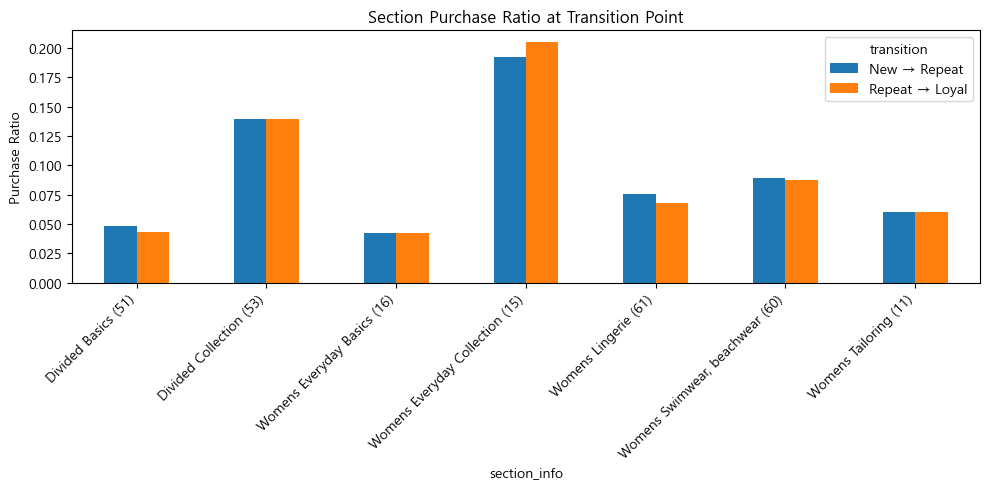

transition,New → Repeat,Repeat → Loyal
section_info,,
Divided Basics (51),0.048217,0.043295
Divided Collection (53),0.139154,0.139386
Womens Everyday Basics (16),0.042170,0.042001
Womens Everyday Collection (15),0.192551,0.204830
Womens Lingerie (61),0.075259,0.067973
"Womens Swimwear, beachwear (60)",0.088889,0.087591
Womens Tailoring (11),0.060152,0.060266


In [105]:
section_pivot = (
    section_top7
    .pivot(
        index="section_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
section_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Section Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

section_pivot

In [106]:
section_30s = (
    transition_tx_art_30s
    .groupby(["transition", "section_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

section_30s["ratio"] = (
    section_30s["purchase_cnt"]
    / section_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 section 선정 (Top 7)
top7_section = (
    section_30s
    .groupby("section_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

section_top7 = section_30s[
    section_30s["section_info"].isin(top7_section)
].copy()

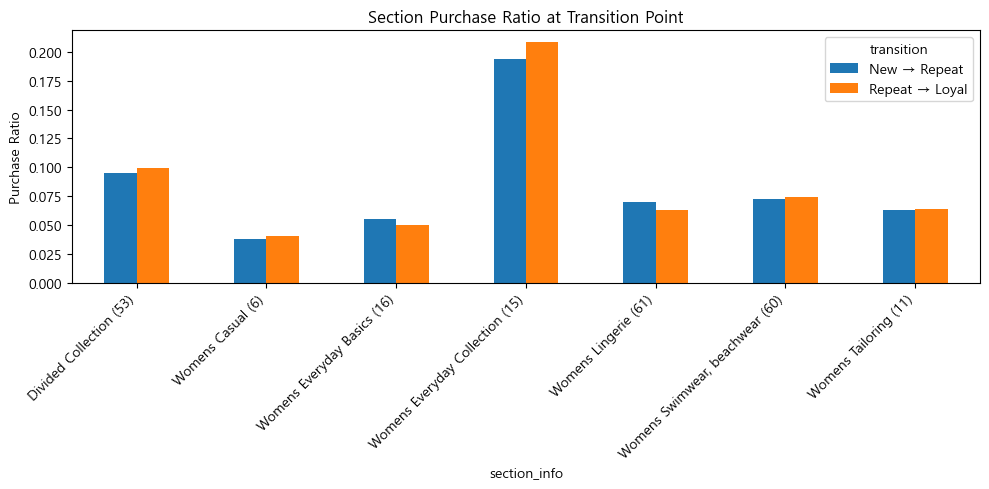

transition,New → Repeat,Repeat → Loyal
section_info,,
Divided Collection (53),0.094714,0.099375
Womens Casual (6),0.037894,0.040310
Womens Everyday Basics (16),0.055455,0.049580
Womens Everyday Collection (15),0.194006,0.208396
Womens Lingerie (61),0.069495,0.062837
"Womens Swimwear, beachwear (60)",0.072928,0.073884
Womens Tailoring (11),0.063333,0.063484


In [107]:
section_pivot = (
    section_top7
    .pivot(
        index="section_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
section_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Section Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

section_pivot

### 상품군 분석 5 (패턴/무늬)
- graphical_appearance_info

In [108]:
# 전환 시점 x 패턴(graphical_appearance_info) 구매 집계
pattern_20s = (
    transition_tx_art_20s
    .groupby(["transition", "graphical_appearance_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
pattern_20s["ratio"] = (
    pattern_20s["purchase_cnt"]
    / pattern_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 패턴 선정 (Top 7)
top7_pattern = (
    pattern_20s
    .groupby("graphical_appearance_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pattern_top7 = pattern_20s[
    pattern_20s["graphical_appearance_info"].isin(top7_pattern)
].copy()

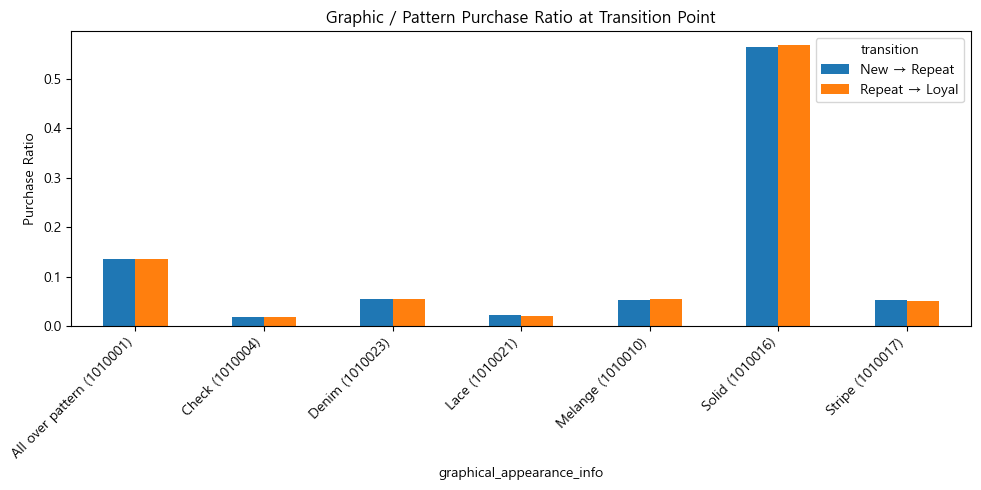

transition,New → Repeat,Repeat → Loyal
graphical_appearance_info,,
All over pattern (1010001),0.135786,0.136975
Check (1010004),0.019460,0.018824
Denim (1010023),0.054184,0.054531
Lace (1010021),0.022375,0.021383
Melange (1010010),0.052628,0.054766
Solid (1010016),0.564633,0.567840
Stripe (1010017),0.052550,0.050501


In [109]:
# 그래프용 pivot
pattern_pivot = (
    pattern_top7
    .pivot(
        index="graphical_appearance_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
pattern_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Graphic / Pattern Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pattern_pivot

In [110]:
# 전환 시점 x 패턴(graphical_appearance_info) 구매 집계
pattern_30s = (
    transition_tx_art_30s
    .groupby(["transition", "graphical_appearance_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
pattern_30s["ratio"] = (
    pattern_30s["purchase_cnt"]
    / pattern_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 패턴 선정 (Top 7)
top7_pattern = (
    pattern_30s
    .groupby("graphical_appearance_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

pattern_top7 = pattern_30s[
    pattern_30s["graphical_appearance_info"].isin(top7_pattern)
].copy()

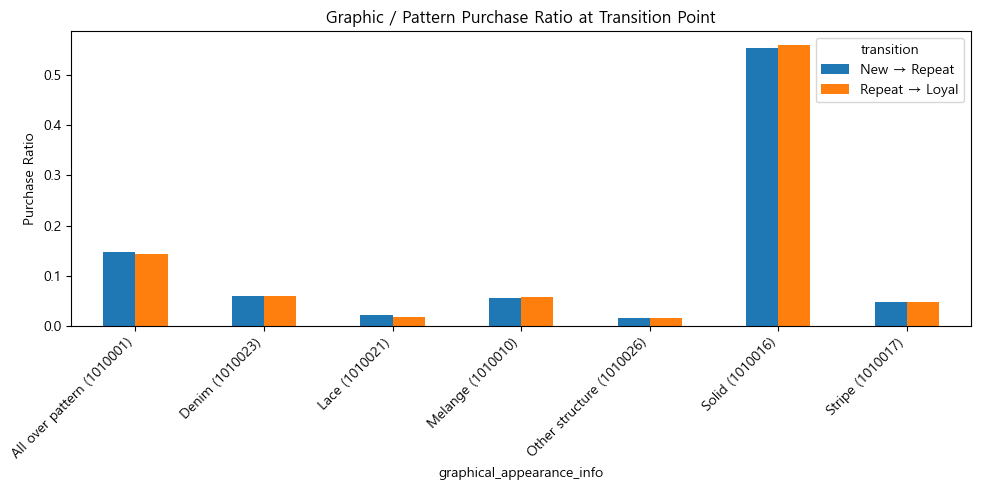

transition,New → Repeat,Repeat → Loyal
graphical_appearance_info,,
All over pattern (1010001),0.148145,0.143781
Denim (1010023),0.060165,0.059496
Lace (1010021),0.022754,0.019455
Melange (1010010),0.057172,0.058849
Other structure (1010026),0.017077,0.016491
Solid (1010016),0.553981,0.558741
Stripe (1010017),0.049162,0.049095


In [111]:
# 그래프용 pivot
pattern_pivot = (
    pattern_top7
    .pivot(
        index="graphical_appearance_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
pattern_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Graphic / Pattern Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

pattern_pivot

### 상품군 분석 6 (색상 계열)
- perceived_colour_master_info

In [112]:
# 전환 시점 × 색상(perceived_colour_master_info) 구매 집계
color_20s = (
    transition_tx_art
    .groupby(["transition", "perceived_colour_master_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
color_20s["ratio"] = (
    color_20s["purchase_cnt"]
    / color_20s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 색상 선정 (Top 7)
top7_color = (
    color_20s
    .groupby("perceived_colour_master_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

color_top7 = color_20s[
    color_20s["perceived_colour_master_info"].isin(top7_color)
].copy()

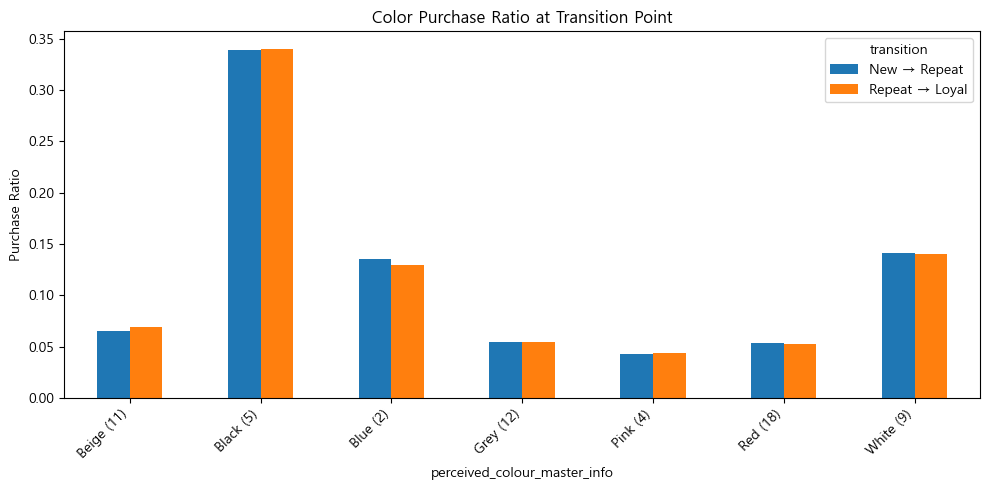

transition,New → Repeat,Repeat → Loyal
perceived_colour_master_info,,
Beige (11),0.065250,0.068562
Black (5),0.338872,0.339991
Blue (2),0.135254,0.129266
Grey (12),0.054351,0.054182
Pink (4),0.042783,0.043454
Red (18),0.053899,0.052675
White (9),0.140804,0.140247


In [113]:
# 그래프용 pivot
color_pivot = (
    color_top7
    .pivot(
        index="perceived_colour_master_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
color_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Color Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

color_pivot

In [114]:
color_30s = (
    transition_tx_art_30s
    .groupby(["transition", "perceived_colour_master_info"], as_index=False)
    .agg(purchase_cnt=("article_id", "count"))
)

# 전환 유형별 구매 비중
color_30s["ratio"] = (
    color_30s["purchase_cnt"]
    / color_30s.groupby("transition")["purchase_cnt"].transform("sum")
)

# 전체 전환 기준 상위 색상 선정 (Top 7)
top7_color = (
    color_30s
    .groupby("perceived_colour_master_info")["purchase_cnt"]
    .sum()
    .sort_values(ascending=False)
    .head(7)
    .index
)

color_top7 = color_30s[
    color_30s["perceived_colour_master_info"].isin(top7_color)
].copy()

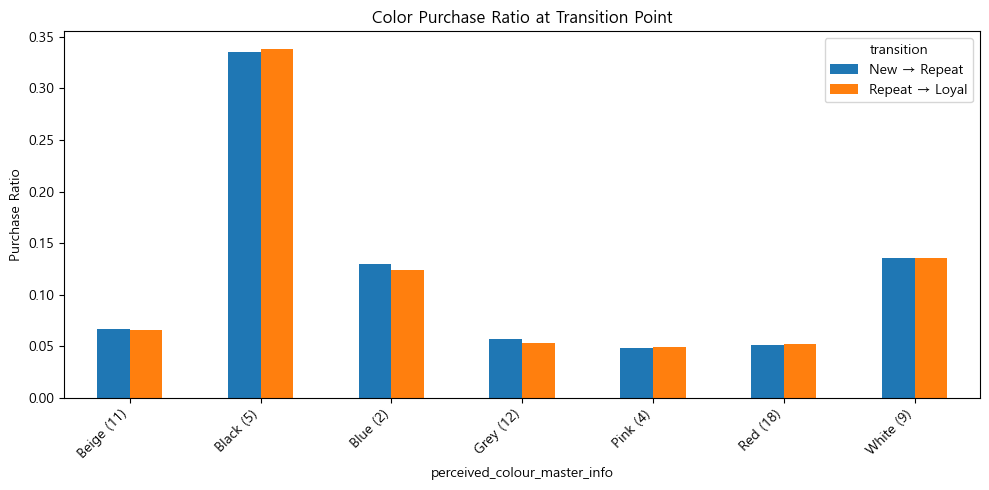

transition,New → Repeat,Repeat → Loyal
perceived_colour_master_info,,
Beige (11),0.066590,0.066286
Black (5),0.335108,0.338381
Blue (2),0.130100,0.123572
Grey (12),0.056996,0.053352
Pink (4),0.048237,0.049149
Red (18),0.051362,0.052436
White (9),0.135381,0.135374


In [115]:
# 그래프용 pivot
color_pivot = (
    color_top7
    .pivot(
        index="perceived_colour_master_info",
        columns="transition",
        values="ratio"
    )
    .fillna(0)
)

# 시각화
color_pivot.plot(kind="bar", figsize=(10, 5))
plt.title("Color Purchase Ratio at Transition Point")
plt.ylabel("Purchase Ratio")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

color_pivot